In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc

from rw import scan_handler

rc('text', usetex=False)
rc('font', family='serif', size=20)
rc('figure', figsize=(12,8))
rc('axes',linewidth=2)

%load_ext autoreload
%autoreload 2

In [2]:
file_path = "/home/cmsdaq/Analysis/Data/reco/run0034.scan"    # series config, read S11 and S21
reader = scan_handler.ScanReader(file_path)        # create the object

In [3]:
d = reader.get_parameters('depth')
locs = np.where((d!=-2) & (d>1e-2))[0]

print(d)
print(locs)

[ 7.64552845e-01  5.87628950e-04  8.60460397e-05  3.49419139e-05
  1.90780379e-05  8.68798814e-05  5.68947039e-05  4.81152595e-05
  7.87262545e-01  9.25962665e-02  1.43481591e-02  3.62817501e-03
  2.65971900e-03  1.04515269e-03  4.57210740e-04  2.30391895e-04
  9.91069765e-05  9.99628559e-06  8.39408229e-01  3.99956902e-01
  3.54292509e-01  6.75882659e-02  3.25144700e-05  4.18377198e-04
  7.25890946e-03  3.21417386e-04  2.13265764e-03  1.17269158e-04
  1.44061268e-04  5.10211479e-05  8.19319872e-05  4.57866697e-05
  8.17581880e-01  4.83986923e-03  1.19659600e-04  2.38856699e-01
  1.59613354e-02  4.36309233e-01  8.53286089e-05  6.51638098e-05
  2.77718457e-04  3.60880146e-04  2.81777940e-03  1.09388446e-03
  6.80052857e-06  5.50852634e-05  7.97471174e-05  3.46976047e-05
 -2.00000000e+00  4.84074936e-05  1.51155192e-04 -2.00000000e+00
  7.55892022e-01  1.06676253e-01  3.06492649e-03  8.21218135e-01
  4.93067254e-03  1.36852659e-03  3.06478196e-04  8.32054573e-04
  1.11115599e-04 -2.00000

0


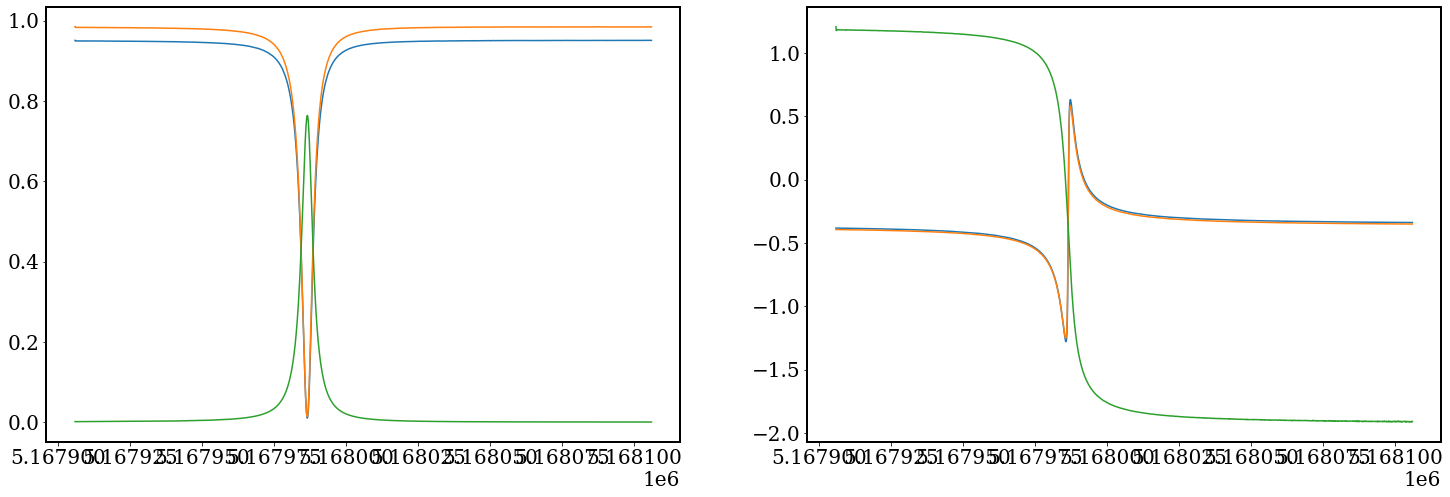

8


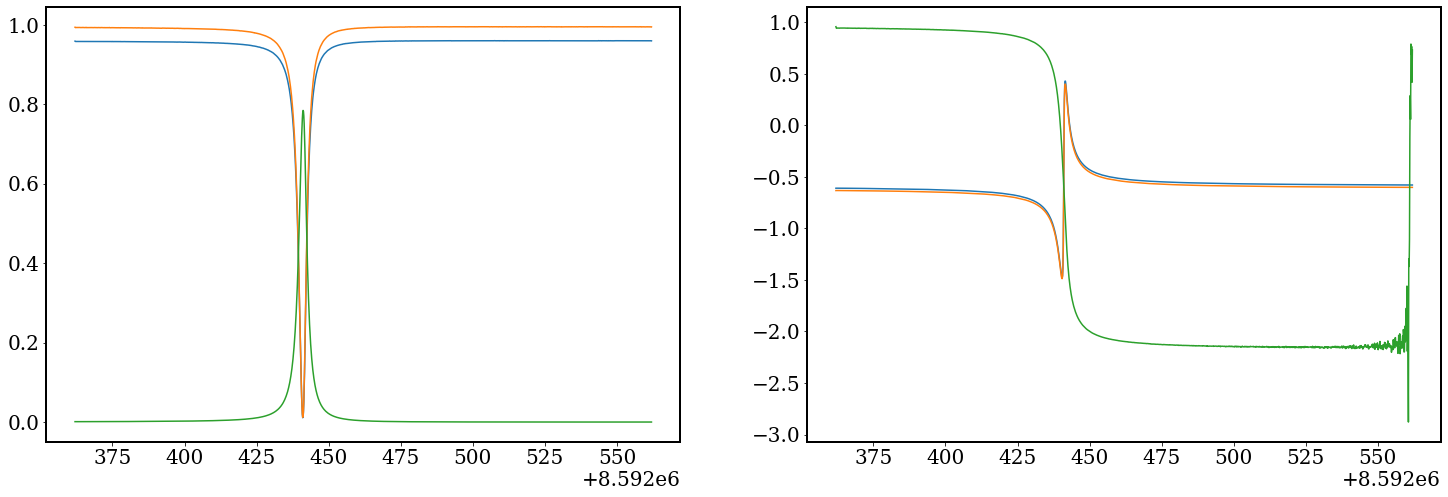

9


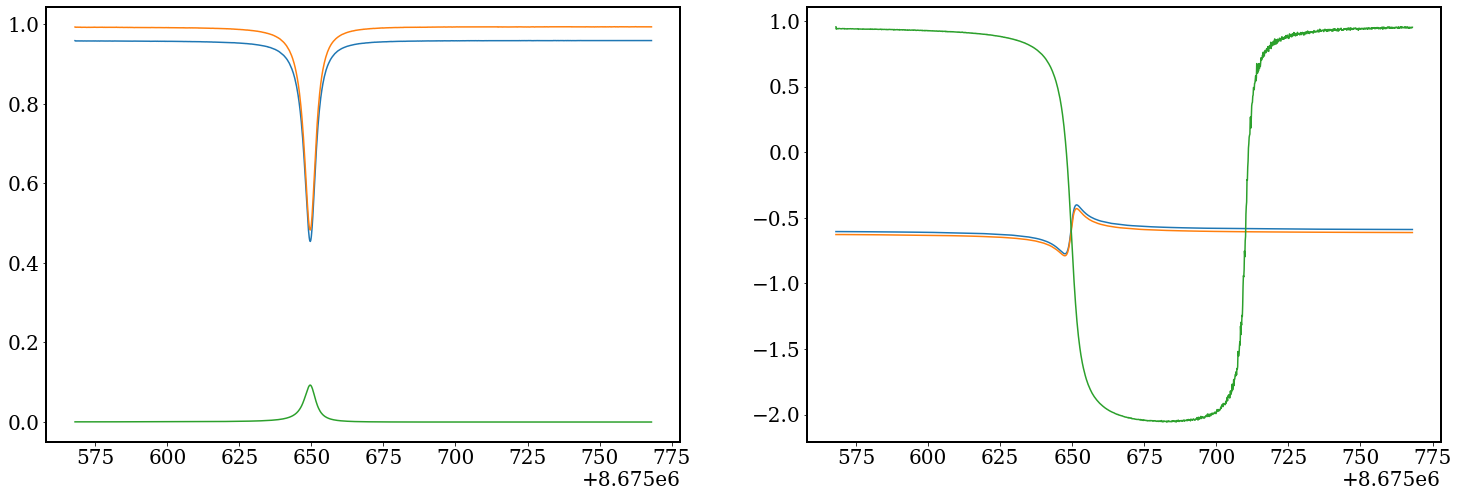

10


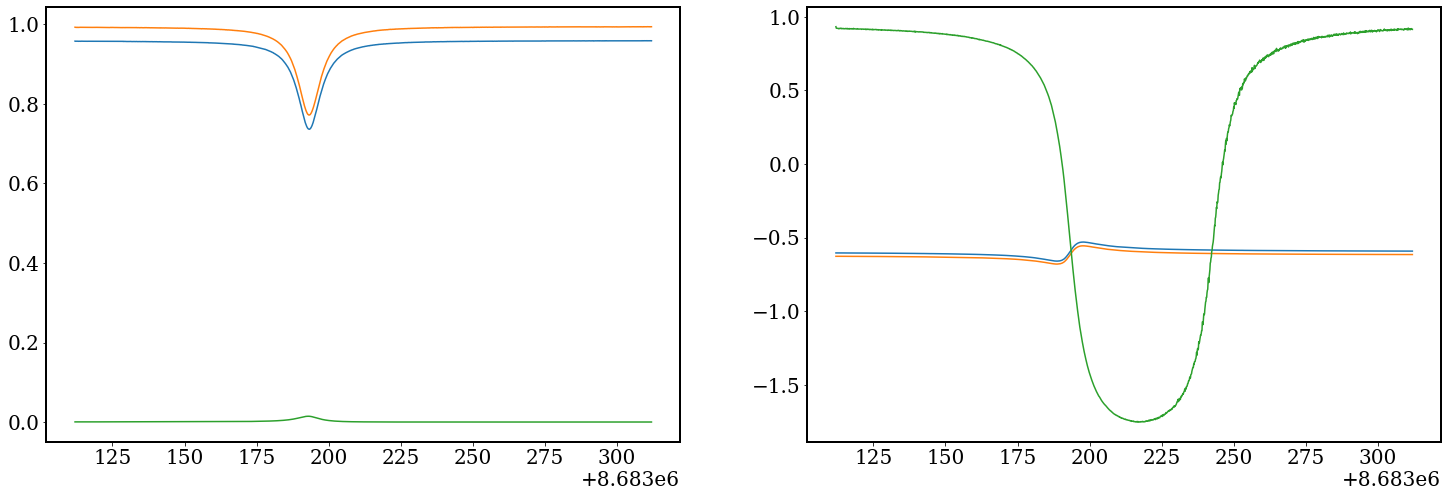

18


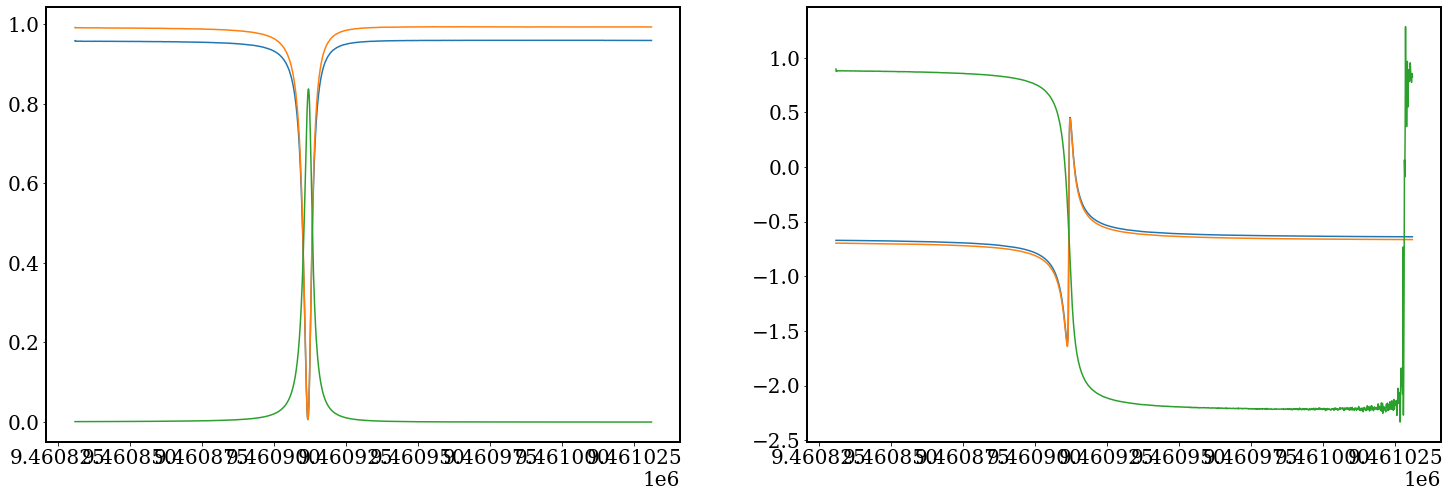

19


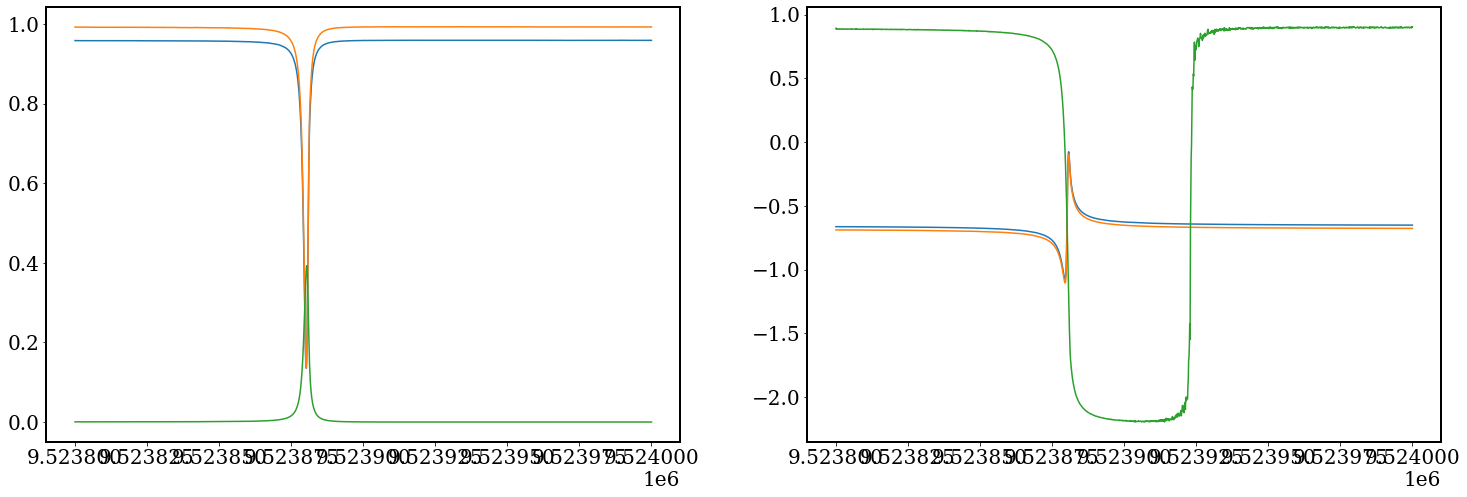

20


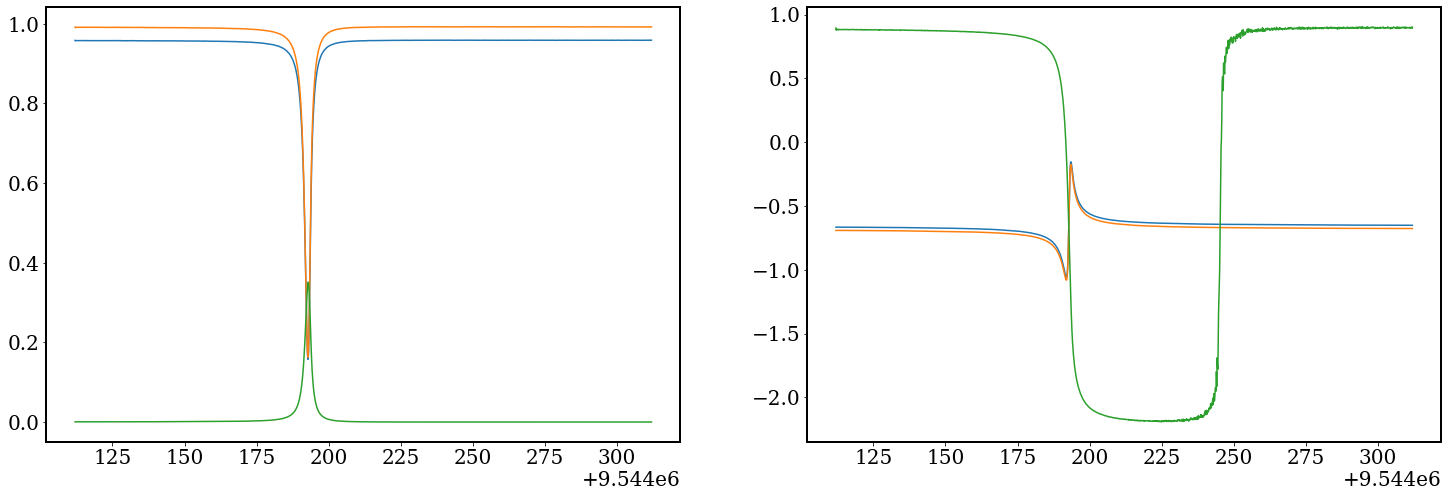

21


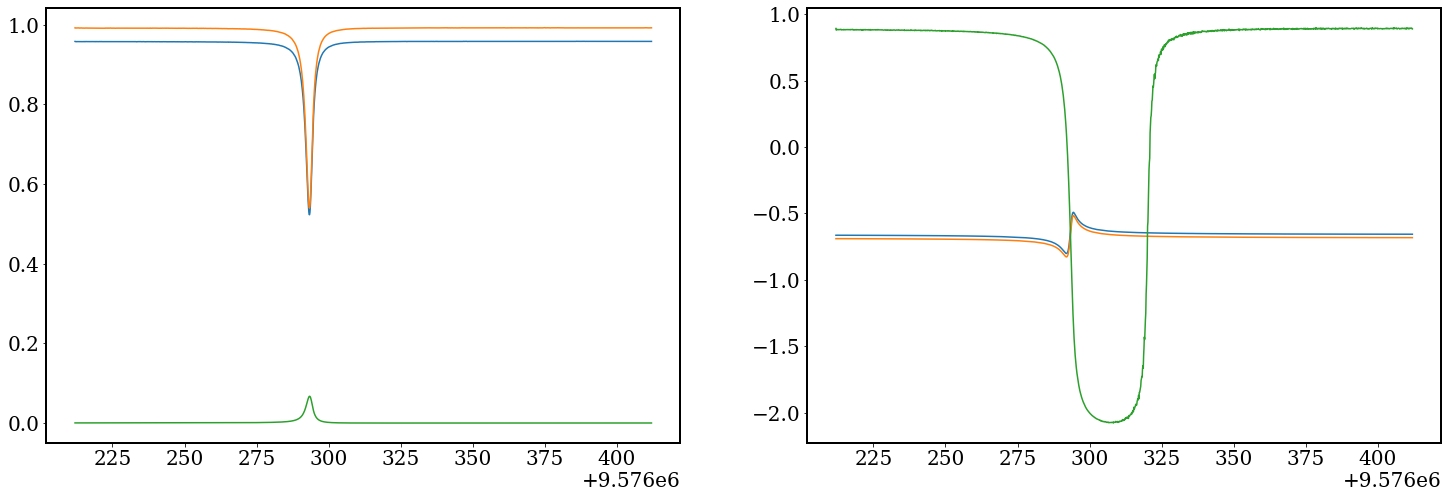

32


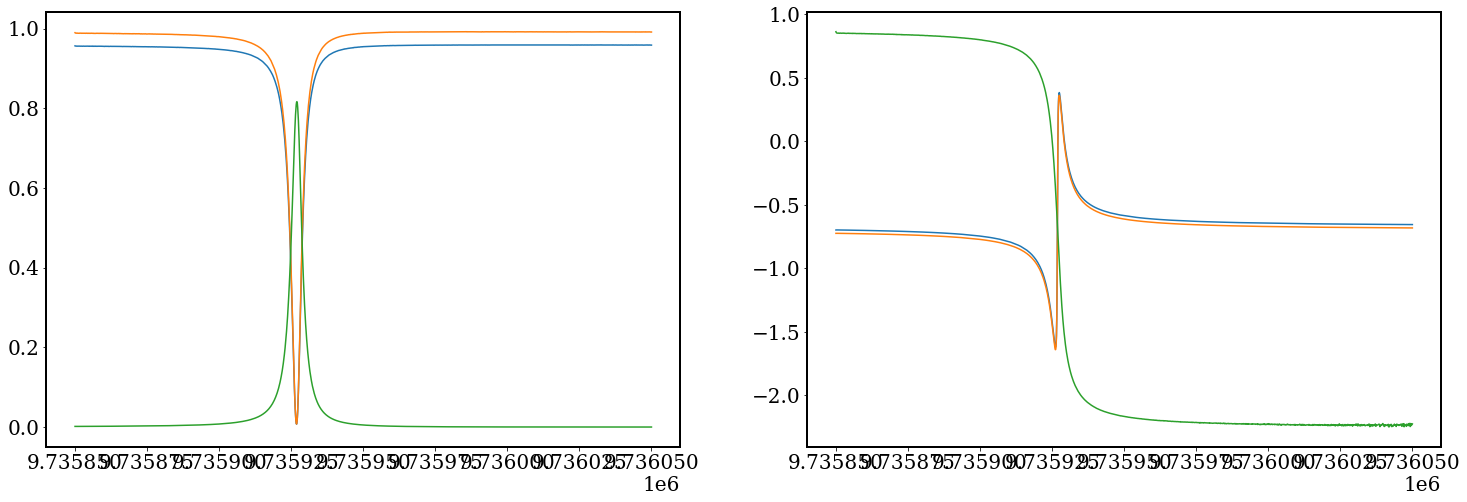

35


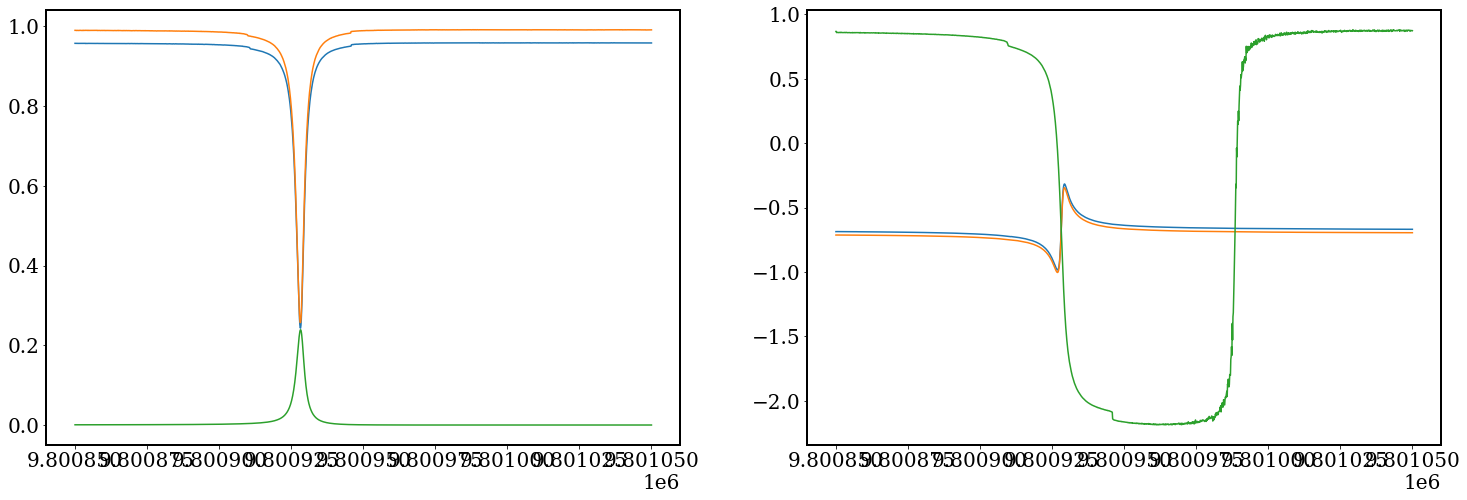

36


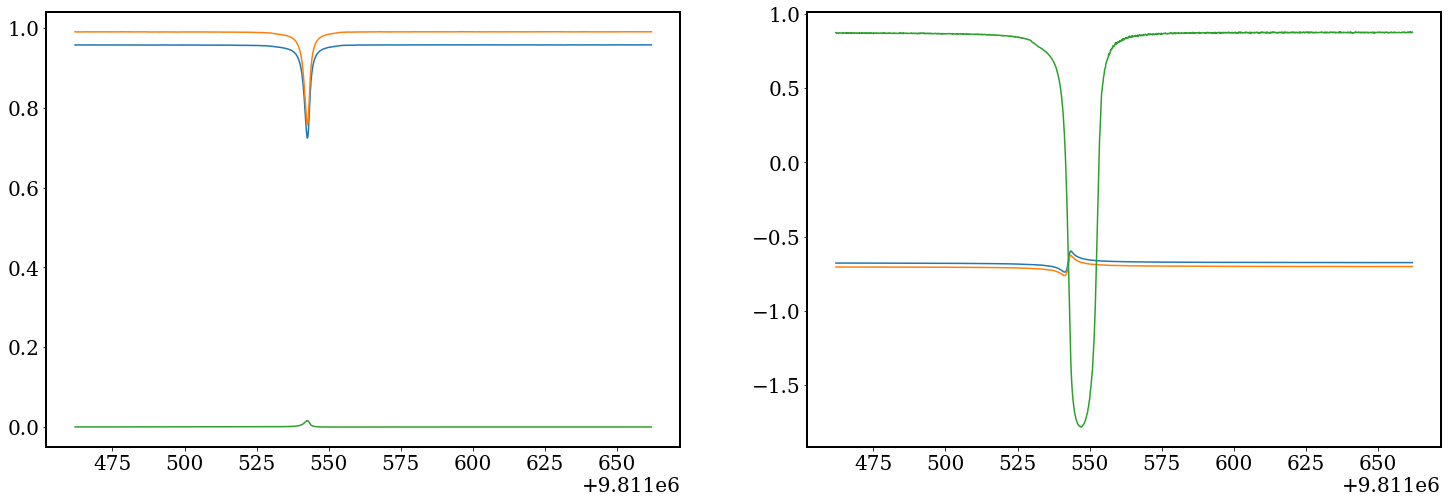

37


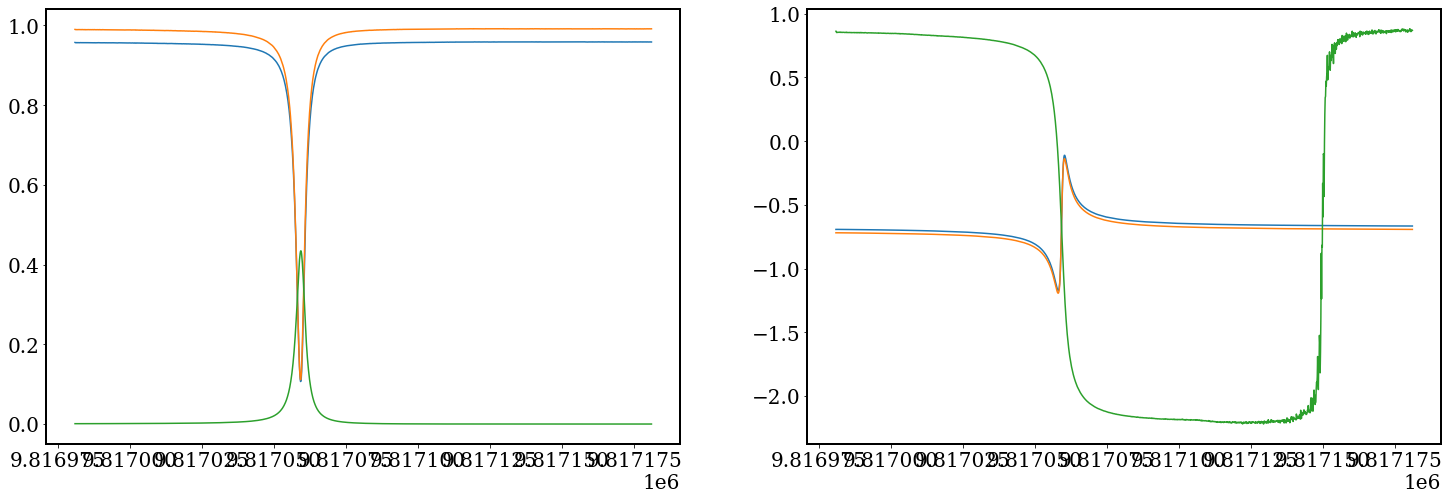

52


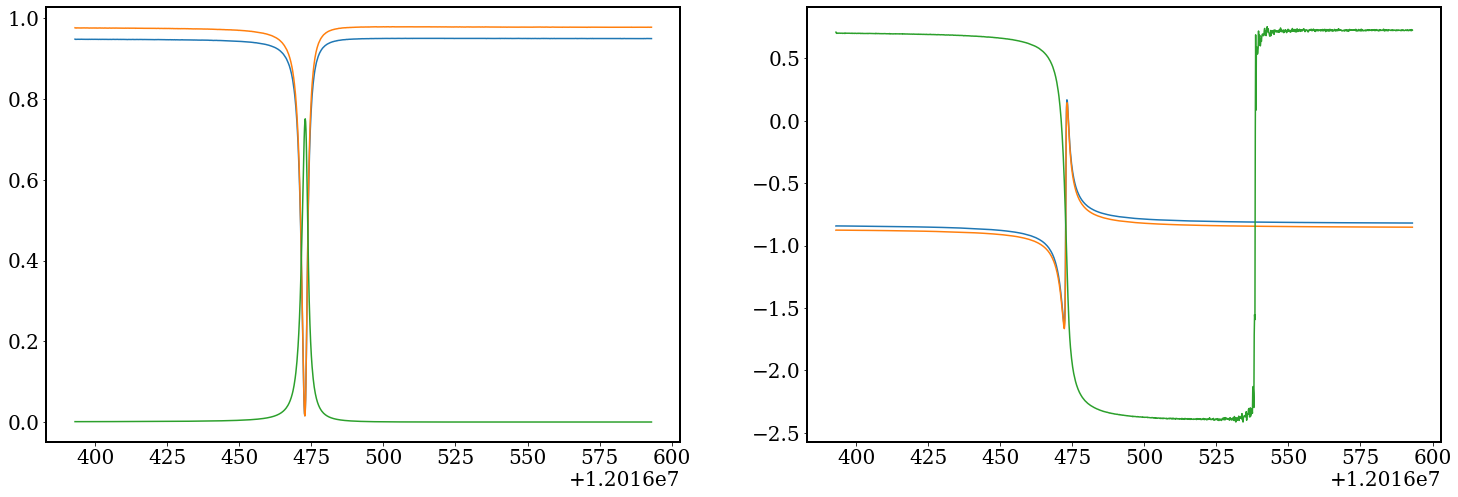

53


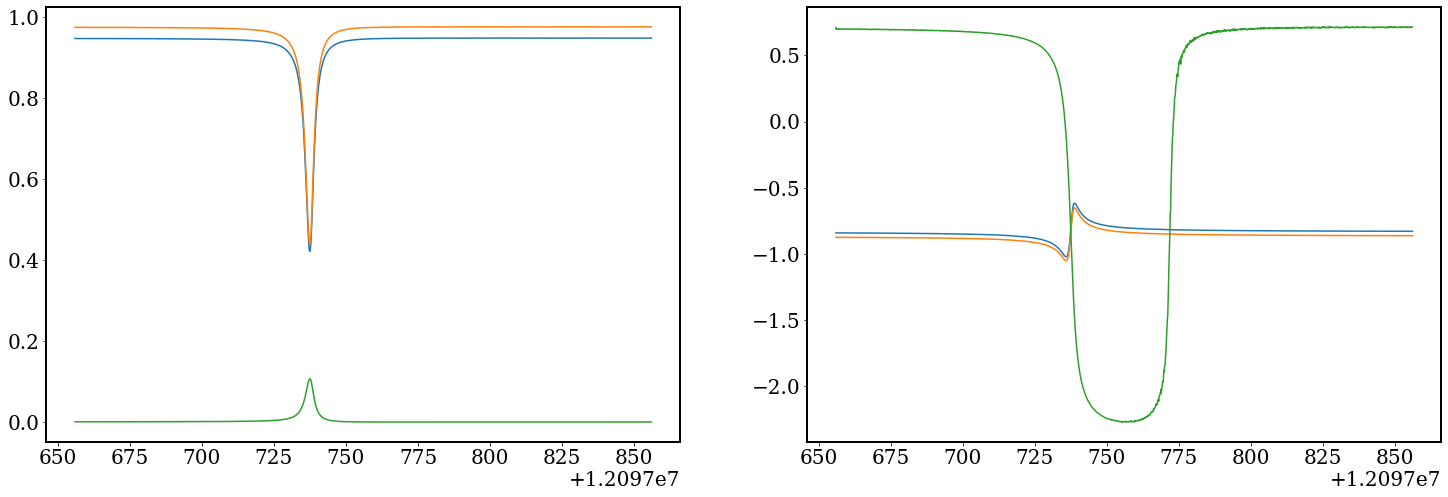

55


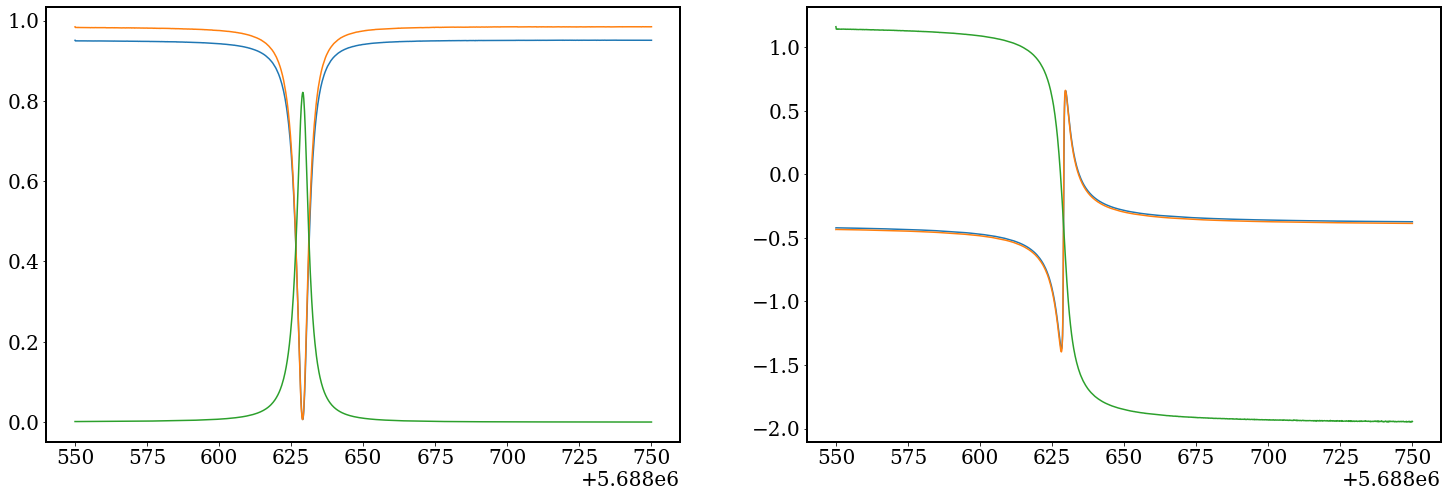

63


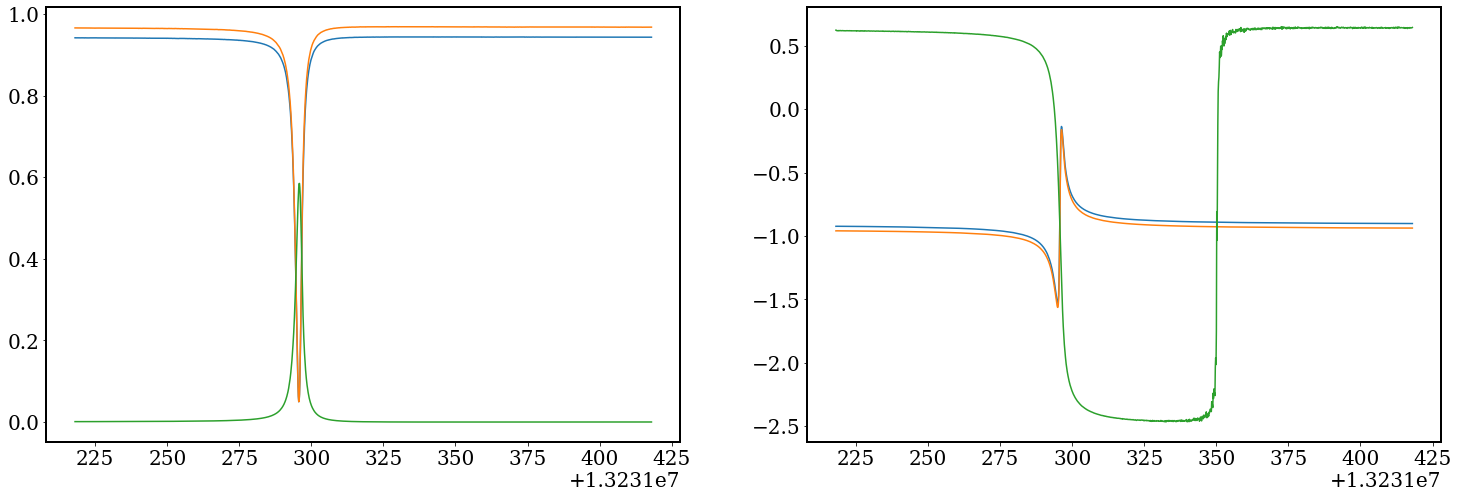

65


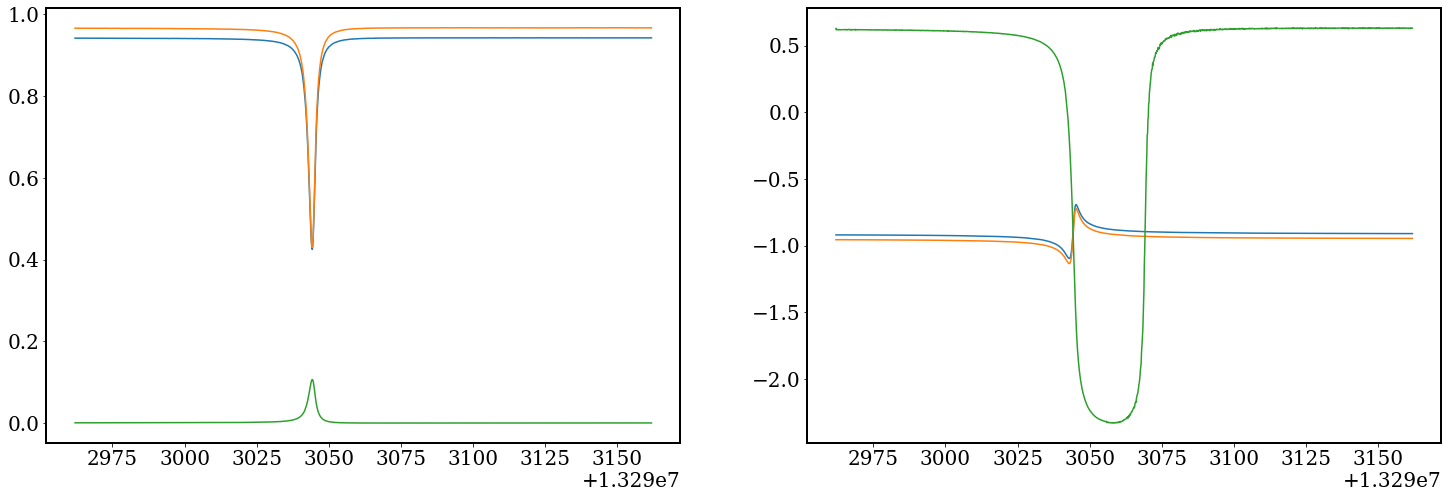

66


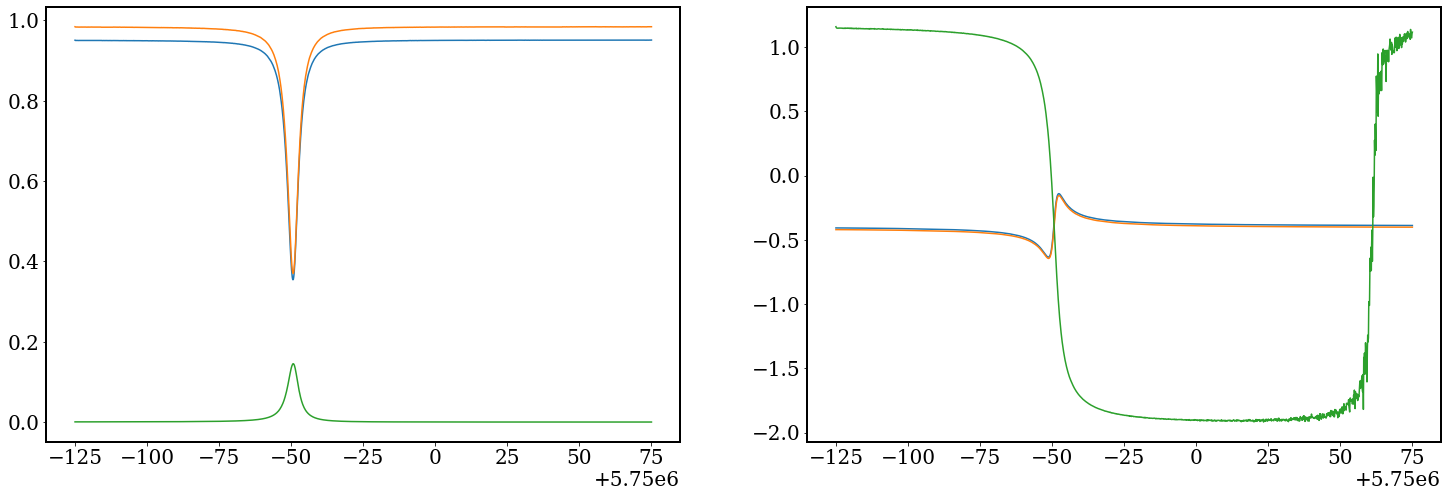

67


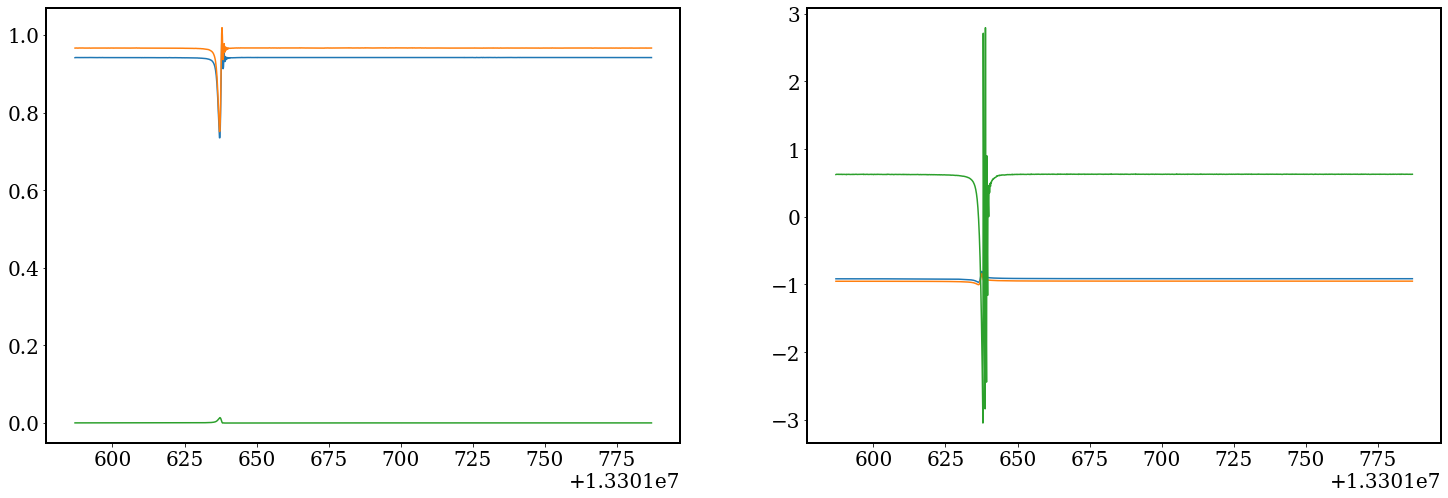

69


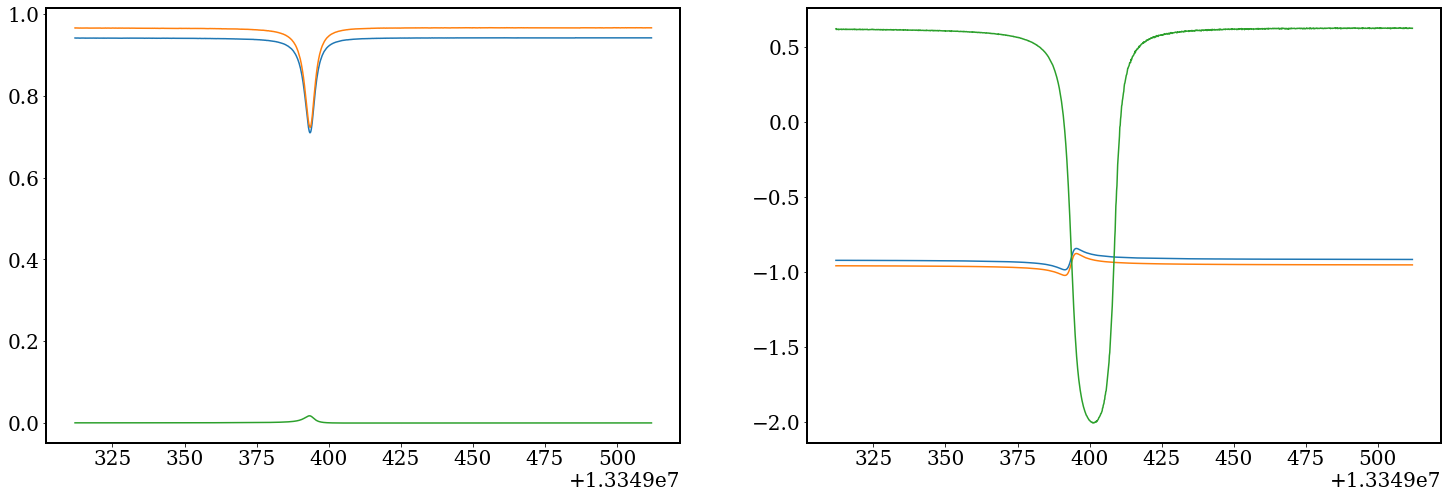

77


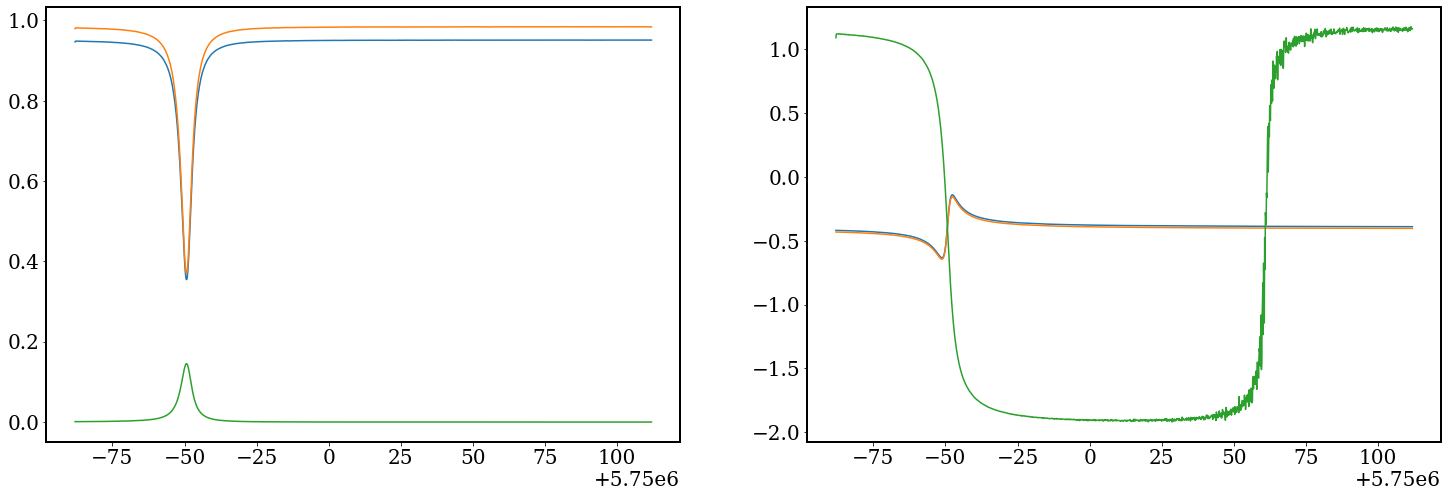

81


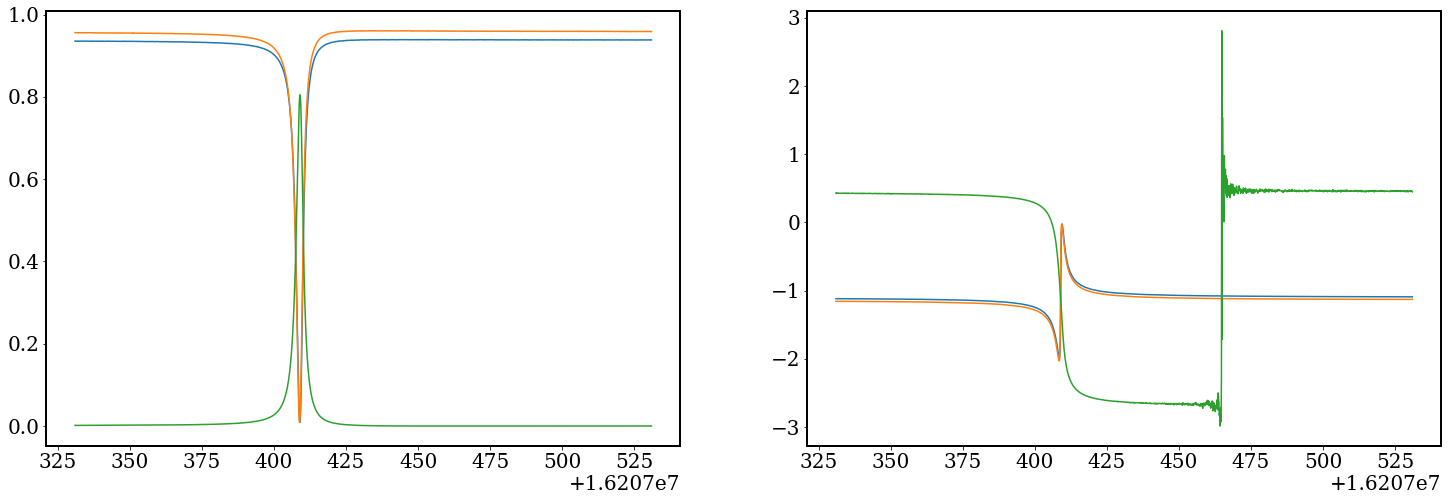

82


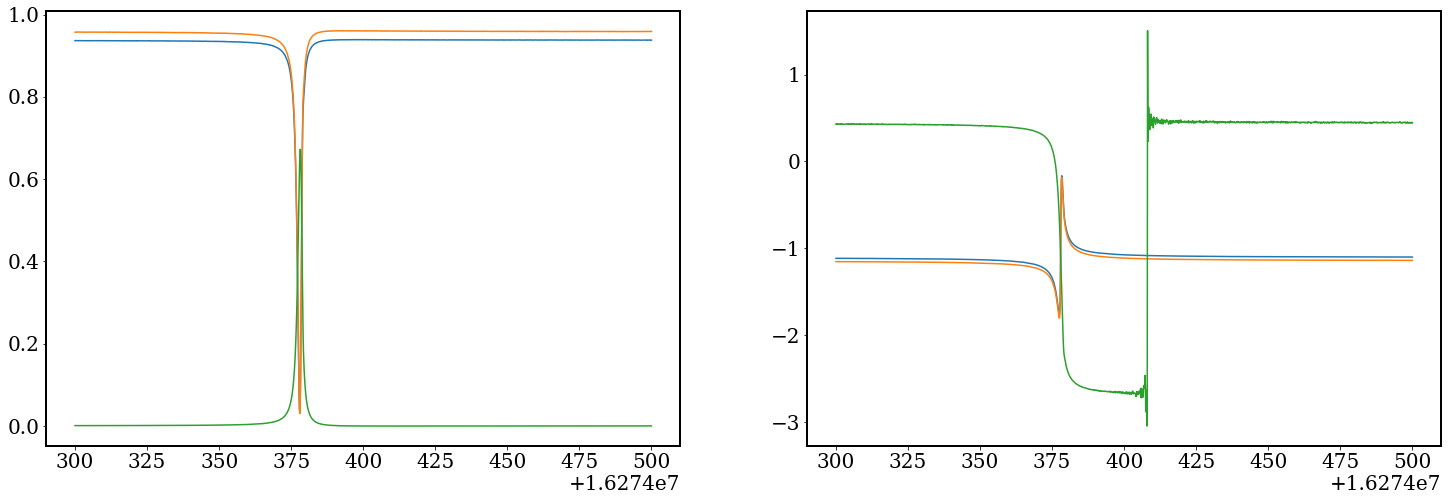

83


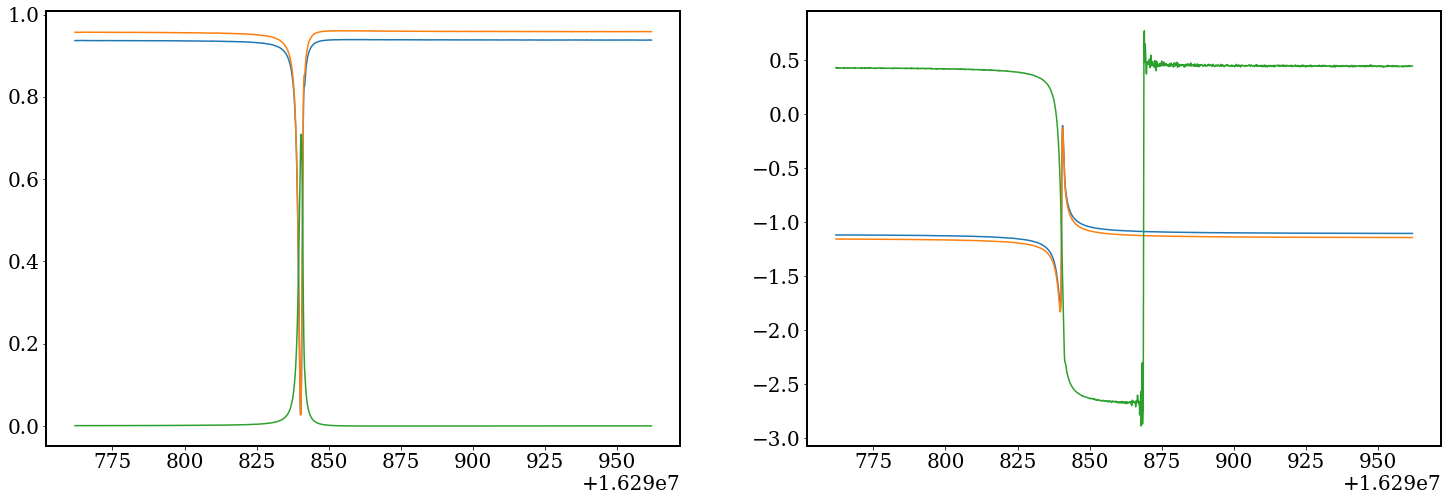

84


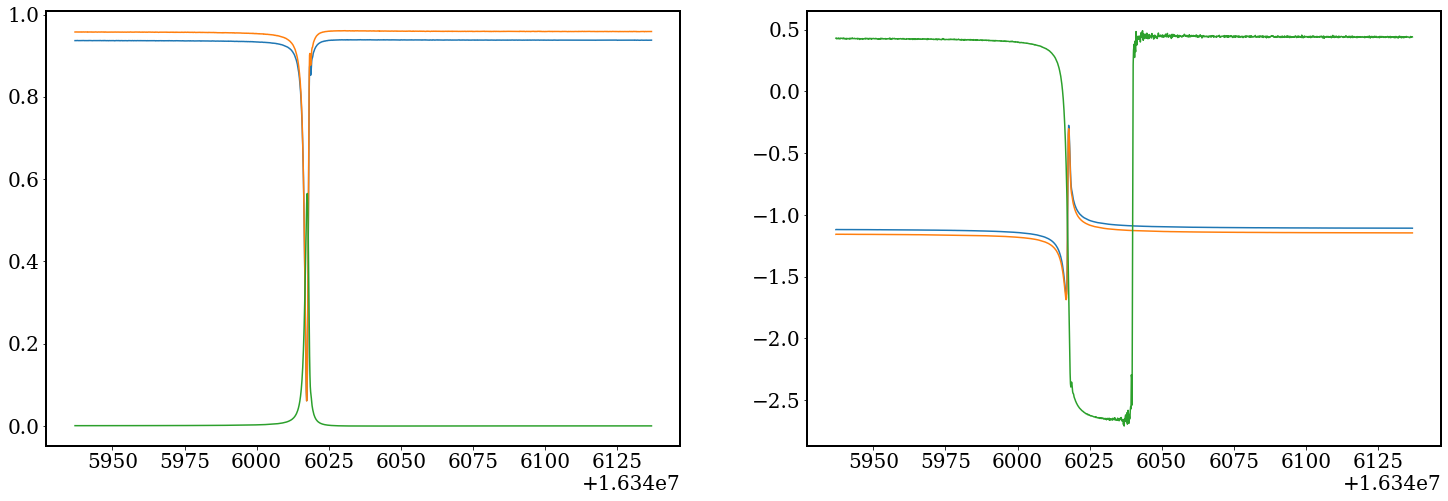

85


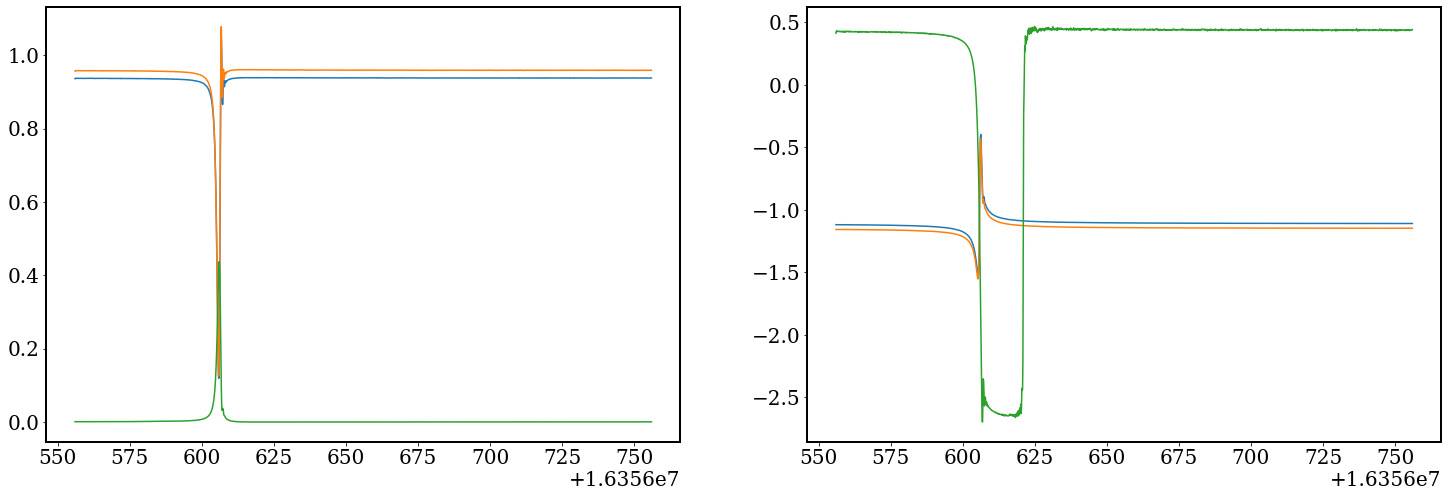

86


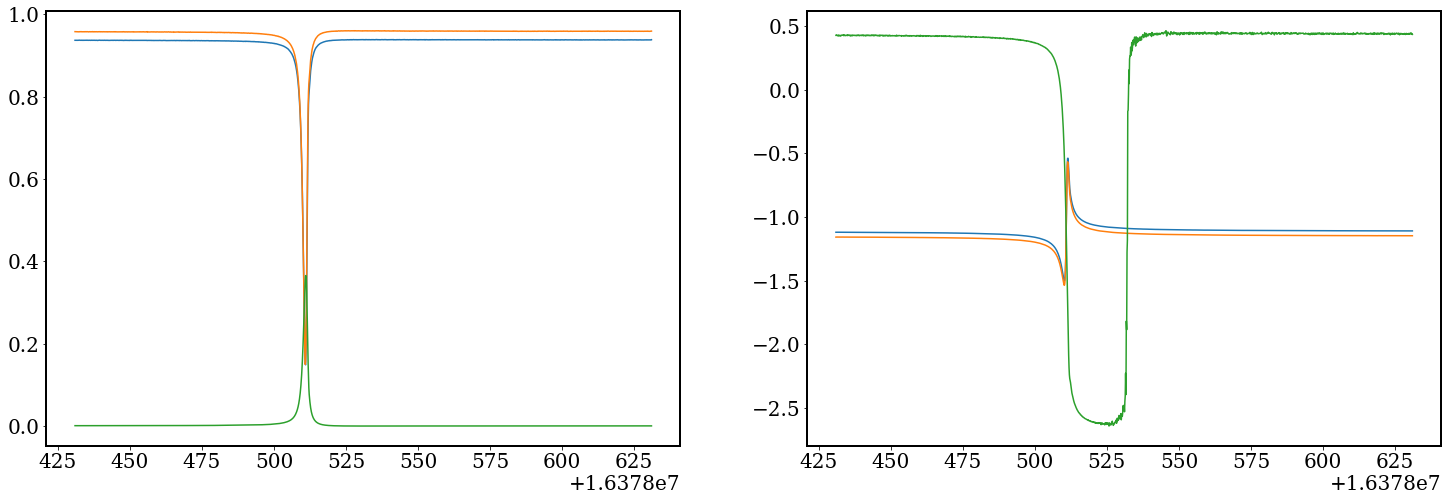

87


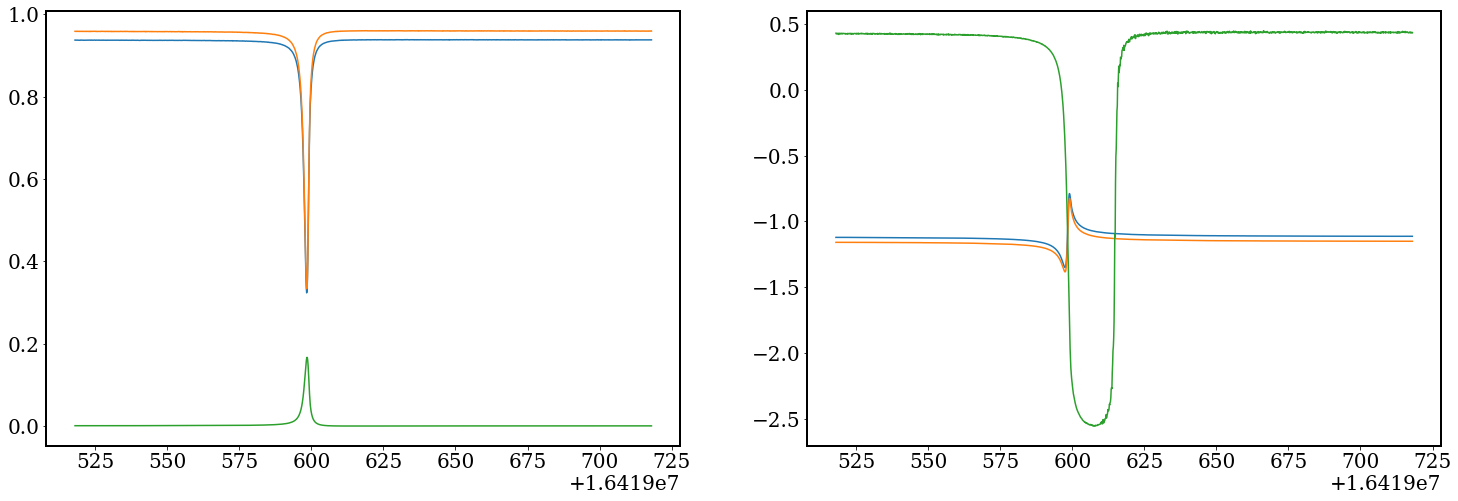

88


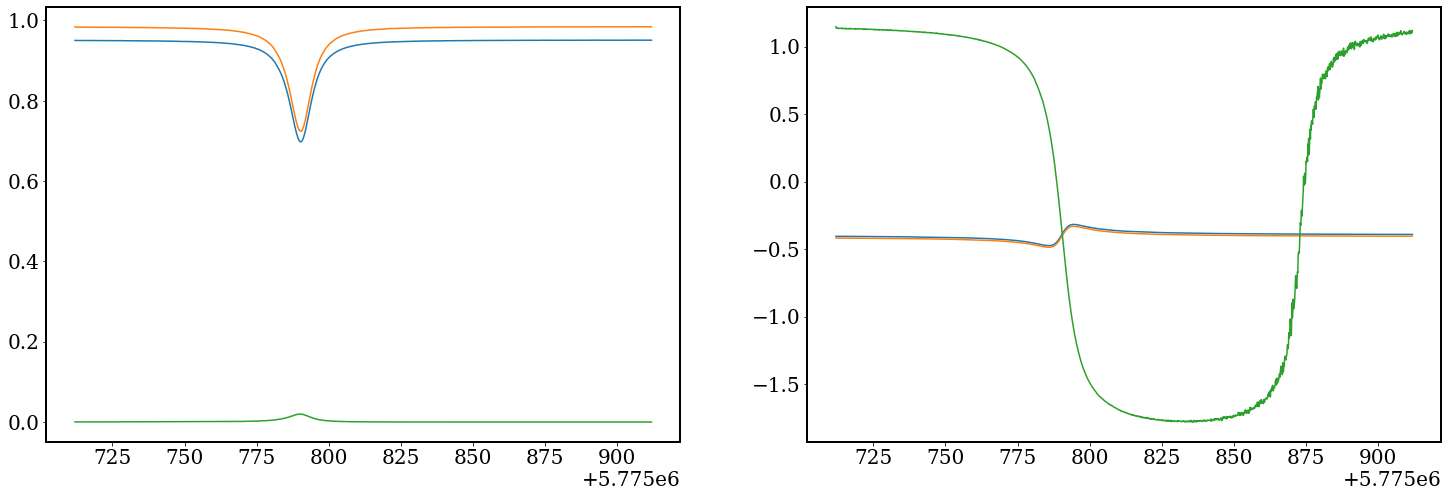

89


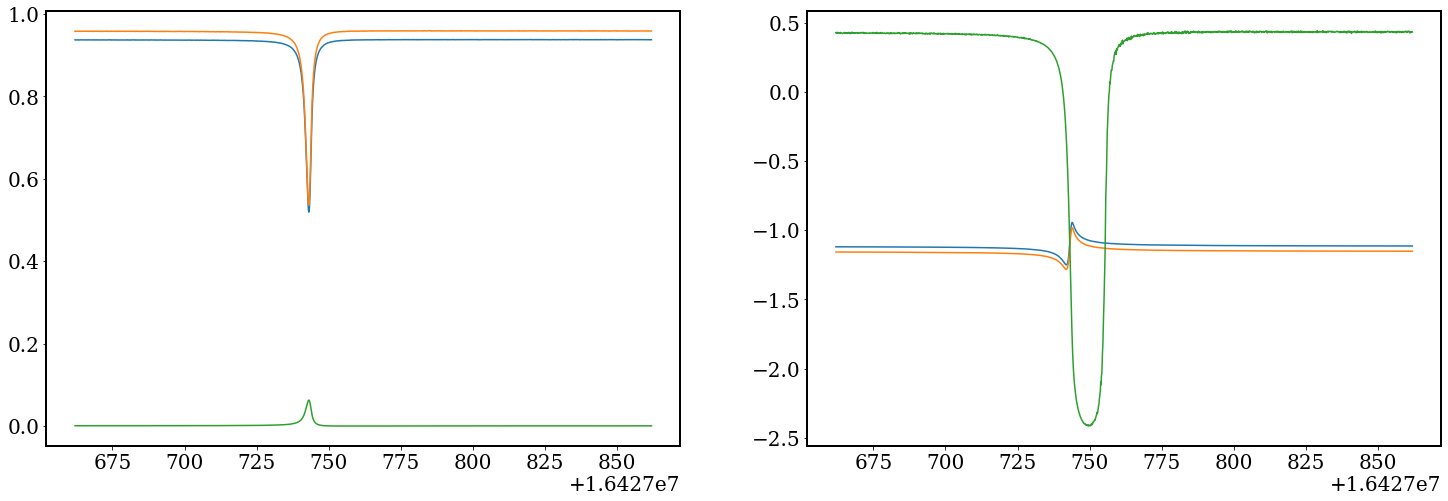

In [4]:

for loc in locs:
    print(loc)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(25)


    power = reader.get_resonance(loc=loc,label='S11')['power']
    power = 10**(power/10)
    phase = reader.get_resonance(loc=loc,label='S11')['phase']
    freq = reader.get_resonance(loc=loc,label='S11')['freq']
    ax1.plot(freq, power)
    ax2.plot(freq, phase)

    power = reader.get_resonance(loc=loc,label='S22')['power']
    power = 10**(power/10)
    phase = reader.get_resonance(loc=loc,label='S22')['phase']
    freq = reader.get_resonance(loc=loc,label='S22')['freq']
    ax1.plot(freq, power)
    ax2.plot(freq, phase)

    power = reader.get_resonance(loc=loc,label='S21')['power']
    power = 10**(power/10)
    phase = reader.get_resonance(loc=loc,label='S21')['phase']
    freq = reader.get_resonance(loc=loc,label='S21')['freq']
    ax1.plot(freq, power)
    ax2.plot(freq, phase)

    plt.show()

0
conversion is: dBm-W
[ 5.56874576e-06  6.25000003e-07  5.16798663e+00 -1.68295220e+02
  8.69778533e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  5.16790600e+00 -1.68295220e+03
   8.69778533e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  5.16810600e+00 -1.68295220e+01
   8.69778533e+03  1.00000000e+02]]
Parametro  1 :  5.639226896666106e-06  +/-  1.5470010838452438e-09
Parametro  2 :  2.3531907154309022e-06  +/-  8.679856960510944e-10
Parametro  3 :  5.167986616175418  +/-  1.1102453564477353e-09
Parametro  4 :  -16.83005426355904  +/-  0.3200611264581415
Parametro  5 :  86.97785327813432  +/-  1.6540788146851932
Parametro  6 :  1.1004790758100538  +/-  0.0010423180950558338
Q = 1.10e+06  +/-  0.00023590211986802443


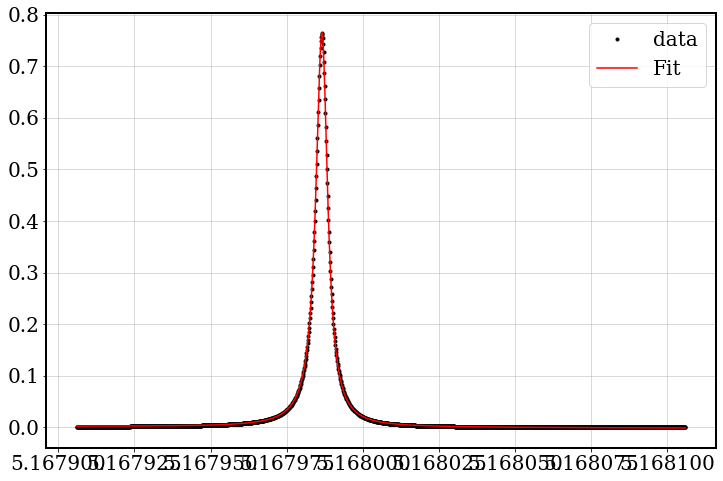

8
conversion is: dBm-W
[ 4.01356600e-06  6.24999998e-07  8.59244112e+00 -1.34118320e+02
  1.15242662e+03  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  8.59236200e+00 -1.34118320e+03
   1.15242662e+02  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  8.59256200e+00 -1.34118320e+01
   1.15242662e+04  1.00000000e+02]]
Parametro  1 :  4.011323365604195e-06  +/-  1.1959163776056183e-09
Parametro  2 :  1.6369540159838213e-06  +/-  6.347702953357085e-10
Parametro  3 :  8.592441181323329  +/-  8.239493615961148e-10
Parametro  4 :  -13.41205885648269  +/-  0.289190737157986
Parametro  5 :  115.2426622969811  +/-  2.484861090346499
Parametro  6 :  1.2123095026101676  +/-  0.001229358471054593
Q = 2.62e+06  +/-  0.00025167150498754974


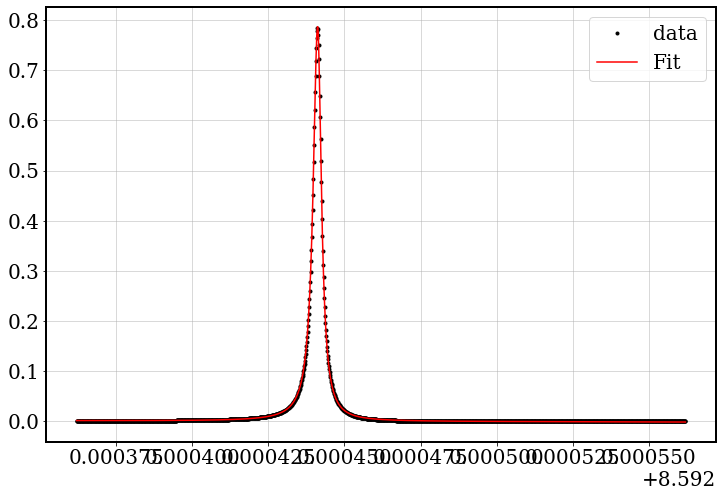

9
conversion is: dBm-W
[ 7.20448374e-07  6.24999998e-07  8.67564963e+00 -2.39822337e+01
  2.08065498e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  8.67556800e+00 -2.39822337e+02
   2.08065498e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  8.67576800e+00 -2.39822337e+00
   2.08065498e+03  1.00000000e+02]]
Parametro  1 :  6.963101061936878e-07  +/-  6.961568829299255e-10
Parametro  2 :  2.4461452762317504e-06  +/-  2.9412413979430257e-09
Parametro  3 :  8.675649738236213  +/-  3.757176735224373e-09
Parametro  4 :  -3.6321984088826627  +/-  0.12854246466960492
Parametro  5 :  31.511853432569225  +/-  1.1151921707470038
Parametro  6 :  1.3433024836539649  +/-  0.0042200888377560055
Q = 1.77e+06  +/-  0.0007679790672556329


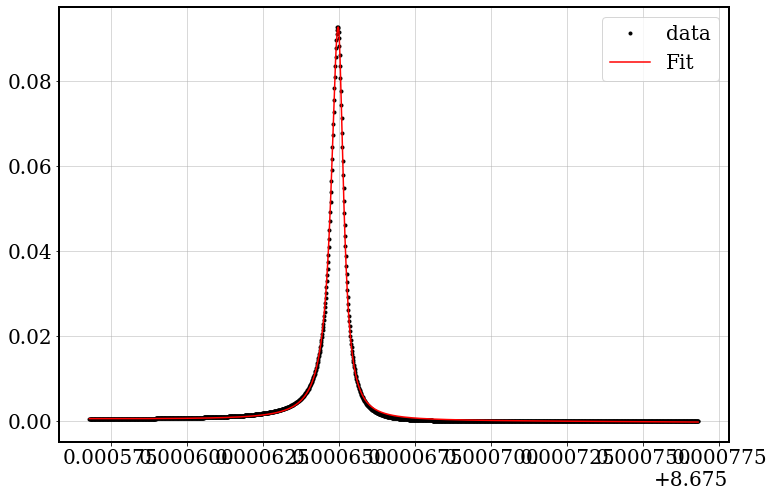

10
conversion is: dBm-W
[ 2.30510392e-07  6.24999998e-07  8.68319300e+00 -9.15166981e+00
  7.94670410e+01  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  8.68311200e+00 -9.15166981e+01
   7.94670410e+00  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  8.68331200e+00 -9.15166981e-01
   7.94670410e+02  1.00000000e+02]]
Parametro  1 :  2.0632186594194685e-07  +/-  5.570607977556109e-10
Parametro  2 :  4.83392499753712e-06  +/-  1.3574341710261312e-08
Parametro  3 :  8.683193441202876  +/-  1.636601609122543e-08
Parametro  4 :  -2.3548125204861656  +/-  0.0646841876236159
Parametro  5 :  20.447438935561827  +/-  0.5616670226458295
Parametro  6 :  1.5989457527267636  +/-  0.011532956260227229
Q = 8.98e+05  +/-  0.0016928289226214352


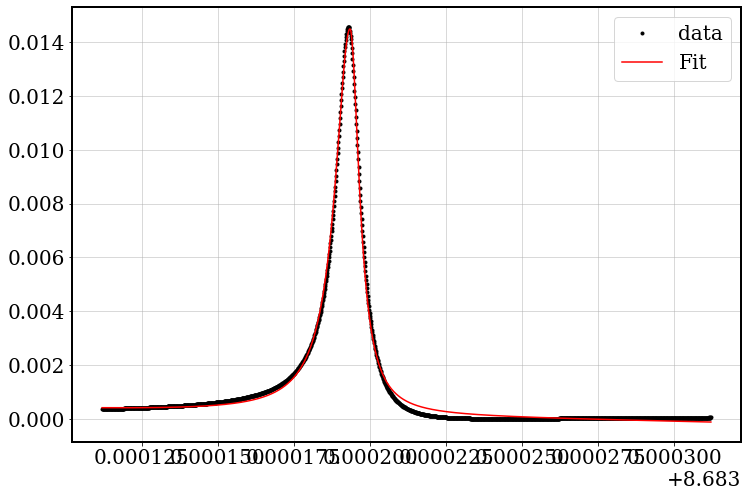

18
conversion is: dBm-W
[ 4.42568016e-06  6.25000007e-07  9.46091200e+00 -1.36400359e+02
  1.29049650e+03  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  9.46083100e+00 -1.36400359e+03
   1.29049650e+02  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  9.46103100e+00 -1.36400359e+01
   1.29049650e+04  1.00000000e+02]]
Parametro  1 :  4.423914208335189e-06  +/-  1.213722064635555e-09
Parametro  2 :  1.6911973272433053e-06  +/-  6.075700470518784e-10
Parametro  3 :  9.460912021671714  +/-  7.892221602375089e-10
Parametro  4 :  -13.640260208709883  +/-  0.28987442814066766
Parametro  5 :  129.04965012529587  +/-  2.7424825970667217
Parametro  6 :  1.1971447473475425  +/-  0.0011238732431898958
Q = 2.80e+06  +/-  0.00023333236977259437


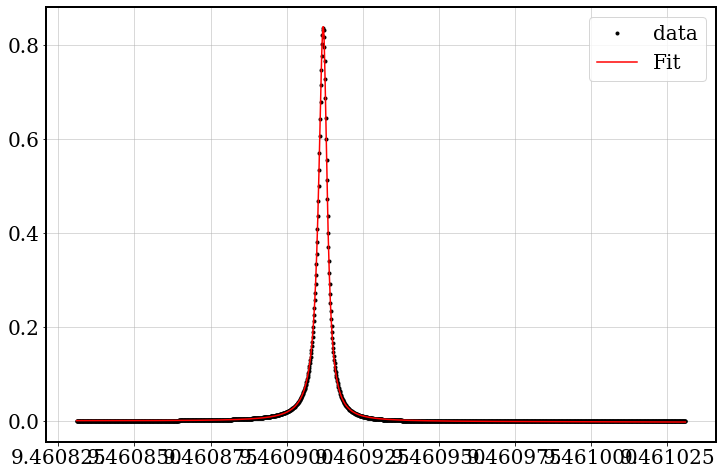

19
conversion is: dBm-W
[ 1.18157344e-06  6.24999998e-07  9.52388037e+00 -3.83997124e+01
  3.65720925e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  9.52380000e+00 -3.83997124e+02
   3.65720925e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  9.52400000e+00 -3.83997124e+00
   3.65720925e+03  1.00000000e+02]]
Parametro  1 :  1.11436678116238e-06  +/-  1.284882477422058e-09
Parametro  2 :  9.343890070084598e-07  +/-  1.1123848744630834e-09
Parametro  3 :  9.523880439475612  +/-  1.4890369719003869e-09
Parametro  4 :  -3.8400249304701544  +/-  0.33531200380495185
Parametro  5 :  36.572092504073574  +/-  3.193478420333696
Parametro  6 :  1.5822686536487618  +/-  0.005257264907809693
Q = 5.10e+06  +/-  0.0007967971373441626


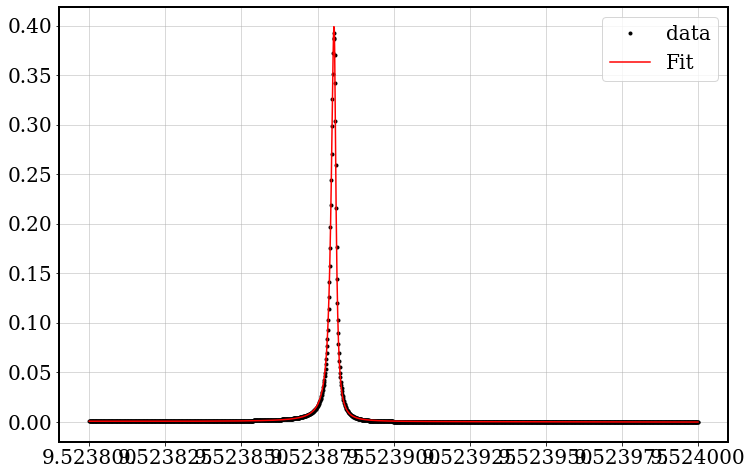

20
conversion is: dBm-W
[ 1.33867354e-06  6.24999998e-07  9.54419288e+00 -4.28022521e+01
  4.08520458e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  9.54411200e+00 -4.28022521e+02
   4.08520458e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  9.54431200e+00 -4.28022521e+00
   4.08520458e+03  1.00000000e+02]]
Parametro  1 :  1.2935288784799898e-06  +/-  7.10904306855838e-10
Parametro  2 :  1.1934927541206241e-06  +/-  7.727904073237763e-10
Parametro  3 :  9.544192964686639  +/-  1.0193285206707238e-09
Parametro  4 :  -4.280283956204485  +/-  0.18435417426649034
Parametro  5 :  40.852045780805945  +/-  1.759515611962535
Parametro  6 :  1.386746121907421  +/-  0.0024178580749038506
Q = 4.00e+06  +/-  0.0004270359066493783


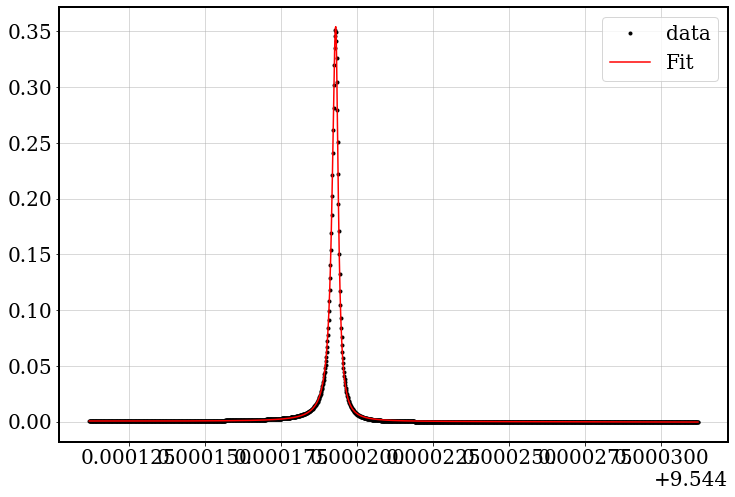

21
conversion is: dBm-W
[ 3.26156136e-07  6.24999998e-07  9.57629337e+00 -1.08805337e+01
  1.04197015e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  9.57621200e+00 -1.08805337e+02
   1.04197015e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  9.57641200e+00 -1.08805337e+00
   1.04197015e+03  1.00000000e+02]]
Parametro  1 :  2.861948250593307e-07  +/-  4.336239667229558e-10
Parametro  2 :  1.4144558213811715e-06  +/-  2.2657264343538703e-09
Parametro  3 :  9.576293506665863  +/-  2.9644009701571298e-09
Parametro  4 :  -2.0852884333143993  +/-  0.09497962732510788
Parametro  5 :  19.96951759207579  +/-  0.9095547248880816
Parametro  6 :  1.5542970203268032  +/-  0.006807155048738096
Q = 3.39e+06  +/-  0.0010478945066175714


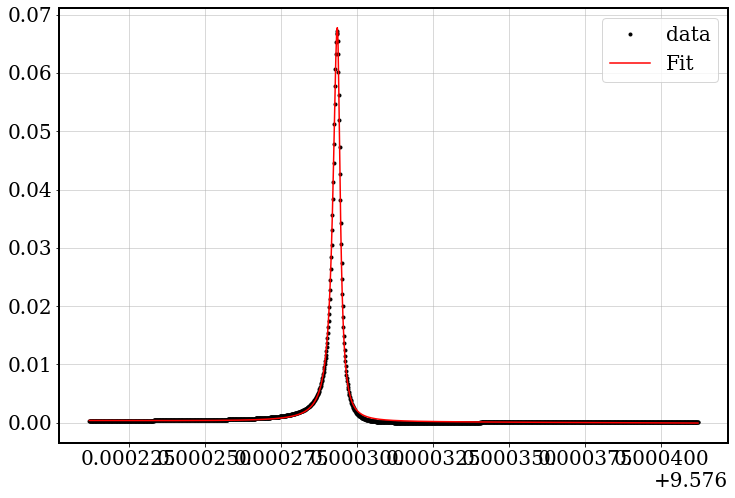

32
conversion is: dBm-W
[ 5.54746482e-06  6.24999998e-07  9.73592700e+00 -2.03626651e+02
  1.98252662e+03  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  9.73585000e+00 -2.03626651e+03
   1.98252662e+02  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  9.73605000e+00 -2.03626651e+01
   1.98252662e+04  1.00000000e+02]]
Parametro  1 :  5.585949509297278e-06  +/-  1.9354917574474893e-09
Parametro  2 :  2.1855049765398847e-06  +/-  1.002661062352734e-09
Parametro  3 :  9.735927004356766  +/-  1.2881474293735932e-09
Parametro  4 :  -20.362939834731474  +/-  0.4102641628049533
Parametro  5 :  198.25266175934115  +/-  3.994312774443897
Parametro  6 :  1.150637923401503  +/-  0.0013625307578107211
Q = 2.23e+06  +/-  0.0002947024699557129


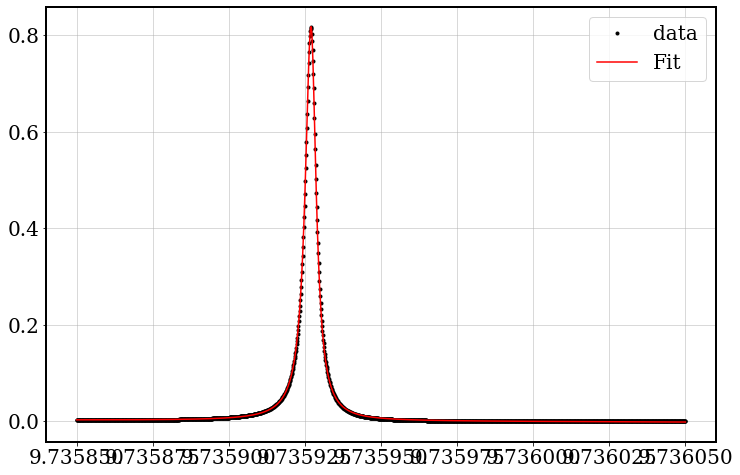

35
conversion is: dBm-W
[ 1.28676362e-06  6.25000007e-07  9.80092825e+00 -4.70958404e+01
  4.61590407e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  9.80085000e+00 -4.70958404e+02
   4.61590407e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  9.80105000e+00 -4.70958404e+00
   4.61590407e+03  1.00000000e+02]]
Parametro  1 :  1.253680457984665e-06  +/-  8.341599921730688e-10
Parametro  2 :  1.689813148482086e-06  +/-  1.4411764784696206e-09
Parametro  3 :  9.800928307554692  +/-  1.8722316434262364e-09
Parametro  4 :  -5.318834309347191  +/-  0.1958347495969497
Parametro  5 :  52.12979845056915  +/-  1.9193670794992017
Parametro  6 :  1.237989234135933  +/-  0.002767693659800253
Q = 2.90e+06  +/-  0.000553975936661408


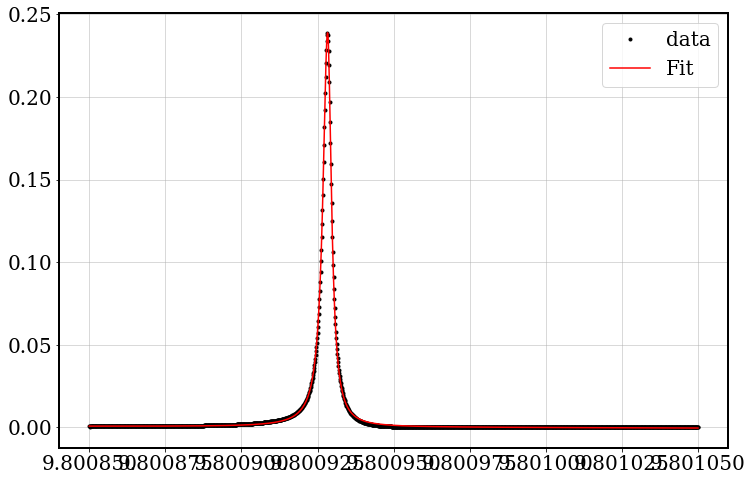

36
conversion is: dBm-W
[ 9.35270184e-08  6.25000007e-07  9.81154262e+00 -2.76780034e+00
  2.71569121e+01  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  9.81146200e+00 -2.76780034e+01
   2.71569121e+00  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  9.81166200e+00 -2.76780034e-01
   2.71569121e+02  1.00000000e+02]]
Parametro  1 :  4.977691928322506e-08  +/-  2.7645652079842704e-10
Parametro  2 :  1.1779359798294953e-06  +/-  4.536527721169991e-09
Parametro  3 :  9.811542801611722  +/-  5.9289507486200854e-09
Parametro  4 :  -0.8993980862610552  +/-  0.04887379800562691
Parametro  5 :  8.824675412384435  +/-  0.4795283839803102
Parametro  6 :  2.314418007523275  +/-  0.027406529345791207
Q = 4.16e+06  +/-  0.00251666934797183


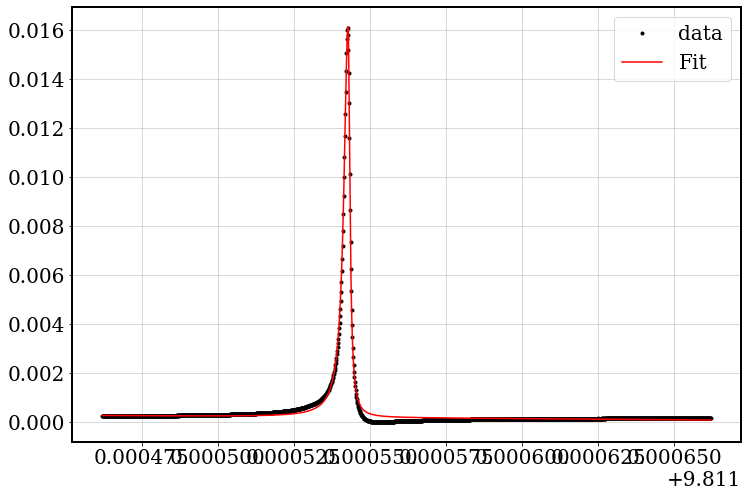

37
conversion is: dBm-W
[ 2.56520408e-06  6.24999998e-07  9.81705937e+00 -9.08588857e+01
  8.91981858e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  9.81698100e+00 -9.08588857e+02
   8.91981858e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  9.81718100e+00 -9.08588857e+00
   8.91981858e+03  1.00000000e+02]]
Parametro  1 :  2.563319591717896e-06  +/-  1.1484973742354908e-09
Parametro  2 :  1.8820195138679639e-06  +/-  1.1123304435395767e-09
Parametro  3 :  9.817059402535165  +/-  1.4384157892562616e-09
Parametro  4 :  -9.086009615013733  +/-  0.26166315353646763
Parametro  5 :  89.19818863798726  +/-  2.5687690934498515
Parametro  6 :  1.1731421761435195  +/-  0.0018018337655263683
Q = 2.61e+06  +/-  0.00038214688494382735


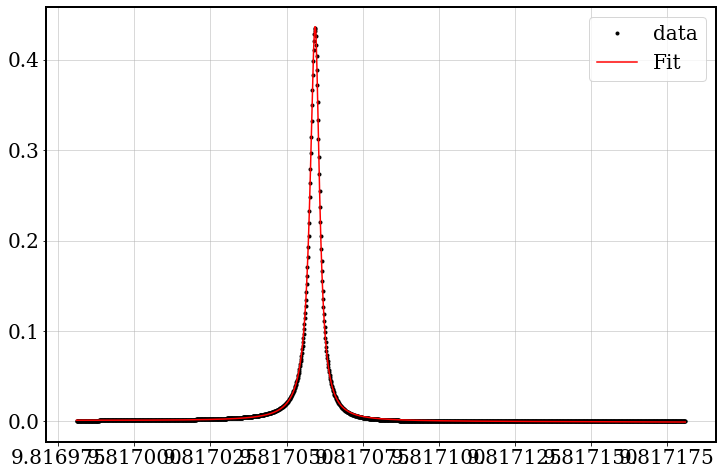

52
conversion is: dBm-W
[ 3.04434609e-06  6.24999998e-07  1.20164729e+01 -1.00949931e+02
  1.21307935e+03  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.20163930e+01 -1.00949931e+03
   1.21307935e+02  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.20165930e+01 -1.00949931e+01
   1.21307935e+04  1.00000000e+02]]
Parametro  1 :  2.980496988714395e-06  +/-  1.3041203277622323e-09
Parametro  2 :  1.2808842570990197e-06  +/-  6.830119443687683e-10
Parametro  3 :  12.016472911624183  +/-  9.041186193729488e-10
Parametro  4 :  -10.095107039288674  +/-  0.3339171521366039
Parametro  5 :  121.30793543925283  +/-  4.012513708543766
Parametro  6 :  1.3306617868543604  +/-  0.0019012023989123056
Q = 4.69e+06  +/-  0.0003529275242326045


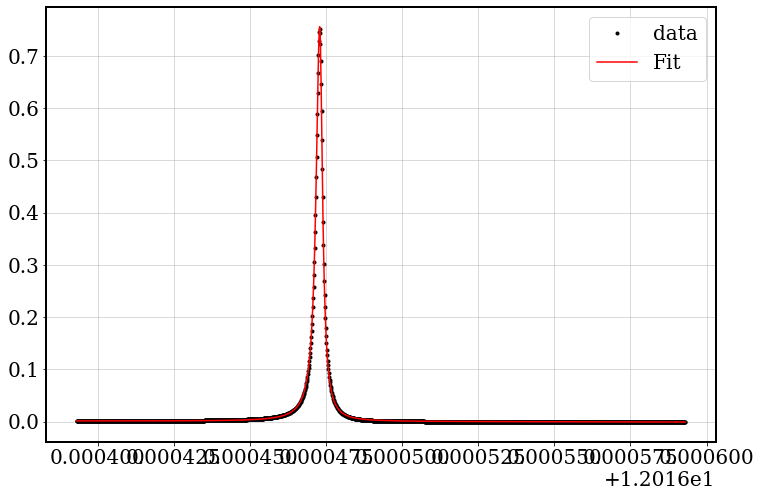

53
conversion is: dBm-W
[ 6.39521662e-07  6.25000007e-07  1.20977375e+01 -2.16738479e+01
  2.62208119e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.20976560e+01 -2.16738479e+02
   2.62208119e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.20978560e+01 -2.16738479e+00
   2.62208119e+03  1.00000000e+02]]
Parametro  1 :  5.809312697567943e-07  +/-  8.391983753291433e-10
Parametro  2 :  1.7960013321737608e-06  +/-  2.9053211833185993e-09
Parametro  3 :  12.097737622888694  +/-  3.788320888447174e-09
Parametro  4 :  -4.192754526771571  +/-  0.1703000812799731
Parametro  5 :  50.723148704288235  +/-  2.0602492391113536
Parametro  6 :  1.4589595685300751  +/-  0.006352967638936749
Q = 3.37e+06  +/-  0.0010546542534748753


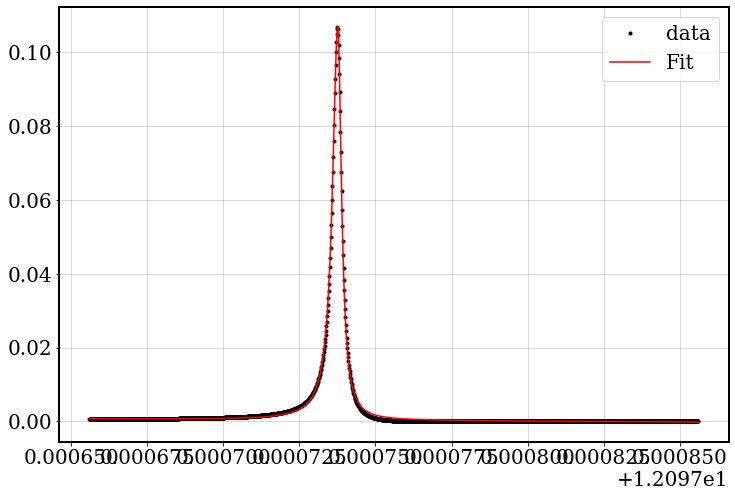

55
conversion is: dBm-W
[ 6.27567765e-06  6.25000003e-07  5.68862900e+00 -2.04576508e+02
  1.16379551e+03  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  5.68855000e+00 -2.04576508e+03
   1.16379551e+02  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  5.68875000e+00 -2.04576508e+01
   1.16379551e+04  1.00000000e+02]]
Parametro  1 :  6.360509378422695e-06  +/-  1.954120494963092e-09
Parametro  2 :  2.47116026329418e-06  +/-  1.0177084071458757e-09
Parametro  3 :  5.688629044484448  +/-  1.298861133220433e-09
Parametro  4 :  -20.458195434265164  +/-  0.39329209134355736
Parametro  5 :  116.37955097173075  +/-  2.2373024398998416
Parametro  6 :  1.101663856647309  +/-  0.0011626929524433663
Q = 1.15e+06  +/-  0.00026280390481211877


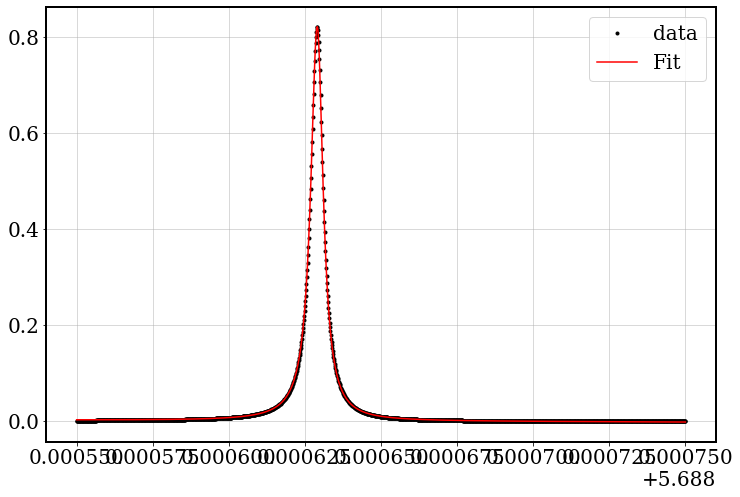

63
conversion is: dBm-W
[ 2.46841729e-06  6.24999998e-07  1.32312959e+01 -9.05240598e+01
  1.19776496e+03  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.32312180e+01 -9.05240598e+02
   1.19776496e+02  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.32314180e+01 -9.05240598e+00
   1.19776496e+04  1.00000000e+02]]
Parametro  1 :  2.390457690610049e-06  +/-  1.2213530157401327e-09
Parametro  2 :  1.3247518890460736e-06  +/-  8.009911997796429e-10
Parametro  3 :  13.231295868073559  +/-  1.0634265733921522e-09
Parametro  4 :  -9.052483673159006  +/-  0.29937769343989523
Parametro  5 :  119.77649562747992  +/-  3.961162065918385
Parametro  6 :  1.3734267346017643  +/-  0.0022395094929711533
Q = 4.99e+06  +/-  0.0004013682041842215


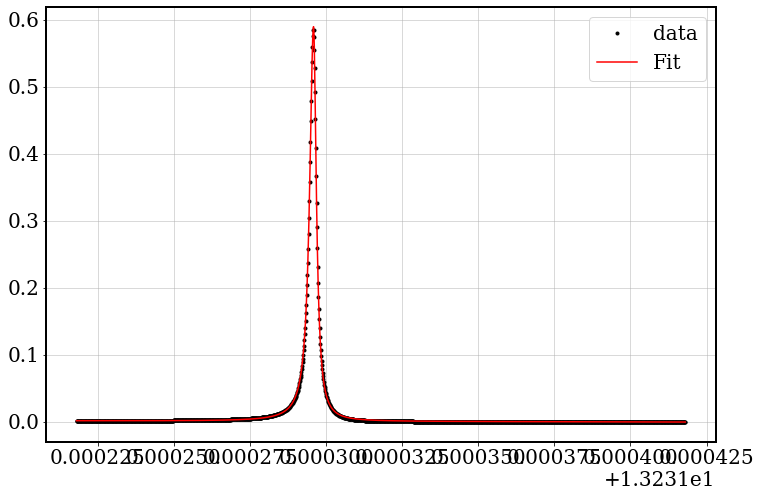

65
conversion is: dBm-W
[ 5.34563661e-07  6.24999998e-07  1.32930444e+01 -1.72893189e+01
  2.29830659e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.32929620e+01 -1.72893189e+02
   2.29830659e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.32931620e+01 -1.72893189e+00
   2.29830659e+03  1.00000000e+02]]
Parametro  1 :  4.5738486968133797e-07  +/-  8.071271164518614e-10
Parametro  2 :  1.441181519478715e-06  +/-  2.5705154250348894e-09
Parametro  3 :  13.293044448789509  +/-  3.413364227312252e-09
Parametro  4 :  -3.689877945467677  +/-  0.16725017097088515
Parametro  5 :  49.05005581442843  +/-  2.2232672022680635
Parametro  6 :  1.610786160277586  +/-  0.008003302676482086
Q = 4.61e+06  +/-  0.0011842242566872838


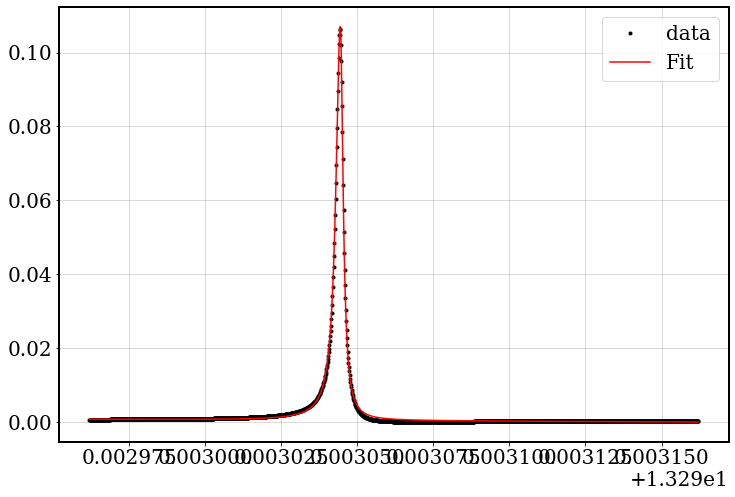

66
conversion is: dBm-W
[ 1.04391756e-06  6.25000003e-07  5.74995075e+00 -4.10585966e+01
  2.36091120e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  5.74987500e+00 -4.10585966e+02
   2.36091120e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  5.75007500e+00 -4.10585966e+00
   2.36091120e+03  1.00000000e+02]]
Parametro  1 :  1.0484811948823152e-06  +/-  4.797738253180988e-10
Parametro  2 :  2.3117379026930486e-06  +/-  1.3762806398118279e-09
Parametro  3 :  5.749950774300875  +/-  1.756037645277655e-09
Parametro  4 :  -4.105946282339682  +/-  0.09768347398751905
Parametro  5 :  23.609112053155147  +/-  0.561677910521494
Parametro  6 :  1.1914769408618828  +/-  0.0018261835700899235
Q = 1.24e+06  +/-  0.00037980898336962296


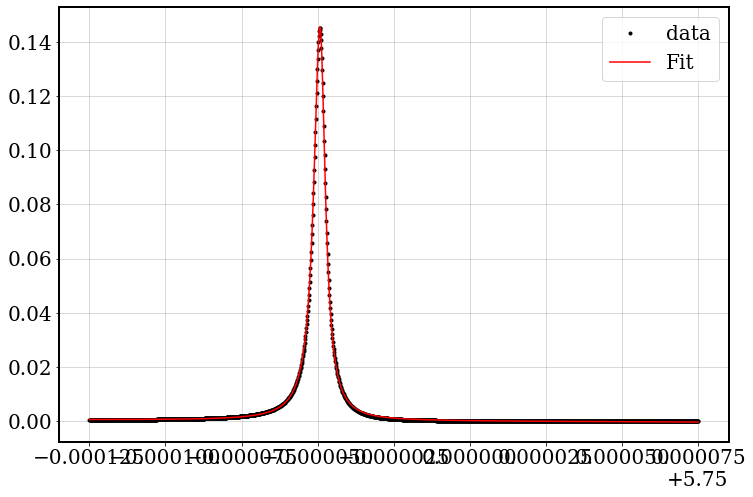

67
conversion is: dBm-W
[ 8.91797776e-08  6.24999998e-07  1.33016372e+01 -2.09062290e+00
  2.78092573e+01  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.33015870e+01 -2.09062290e+01
   2.78092573e+00  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.33017870e+01 -2.09062290e-01
   2.78092573e+02  1.00000000e+02]]
Parametro  1 :  1.412560993351991e-08  +/-  6.122530651750528e-10
Parametro  2 :  5.93851334120194e-07  +/-  7.01804415885024e-09
Parametro  3 :  13.301637526678658  +/-  1.1042284765913265e-08
Parametro  4 :  -2.08533366822693  +/-  0.07523894986201012
Parametro  5 :  27.73877339705307  +/-  1.0008051132734432
Parametro  6 :  5.15258452101583  +/-  0.3197375479109989
Q = 1.12e+07  +/-  0.009297179387727316


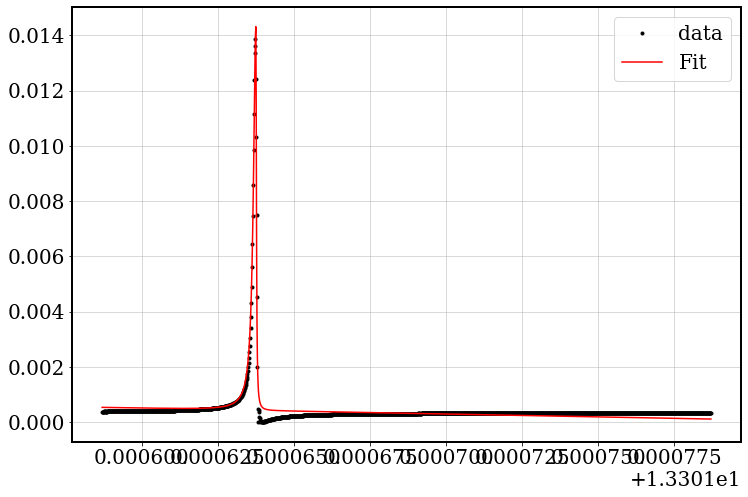

69
conversion is: dBm-W
[ 1.79665565e-07  6.24999998e-07  1.33493934e+01 -6.03725656e+00
  8.05947233e+01  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.33493120e+01 -6.03725656e+01
   8.05947233e+00  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.33495120e+01 -6.03725656e-01
   8.05947233e+02  1.00000000e+02]]
Parametro  1 :  1.0159688622813333e-07  +/-  7.293046898836963e-10
Parametro  2 :  2.2768788295711907e-06  +/-  1.1038694177660641e-08
Parametro  3 :  13.34939381116074  +/-  1.3736765786279384e-08
Parametro  4 :  -2.1009129242418116  +/-  0.09275691659852917
Parametro  5 :  28.04624609488513  +/-  1.2382506302610445
Parametro  6 :  2.4483595937458267  +/-  0.035740497727051644
Q = 2.93e+06  +/-  0.0030165781349169524


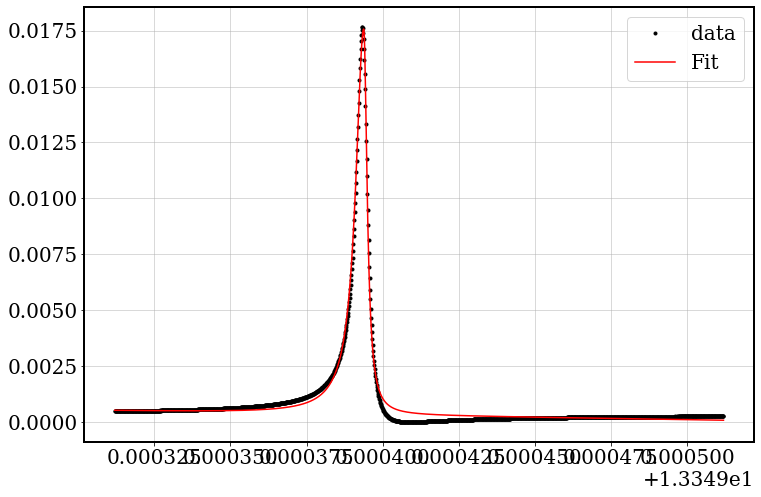

77
conversion is: dBm-W
[ 1.02192779e-06  6.24999998e-07  5.74995062e+00 -9.51501767e+01
  5.47119764e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  5.74991200e+00 -9.51501767e+02
   5.47119764e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  5.75011200e+00 -9.51501767e+00
   5.47119764e+03  1.00000000e+02]]
Parametro  1 :  1.0344257829776714e-06  +/-  1.1271385161525052e-09
Parametro  2 :  2.279859790332283e-06  +/-  3.1515016050769242e-09
Parametro  3 :  5.749950744369029  +/-  3.8764993916714375e-09
Parametro  4 :  -9.515100527350452  +/-  0.23337801304726613
Parametro  5 :  54.71197643226232  +/-  1.3419284484389462
Parametro  6 :  1.1862116817551167  +/-  0.004065537968922846
Q = 1.26e+06  +/-  0.0008501617968152879


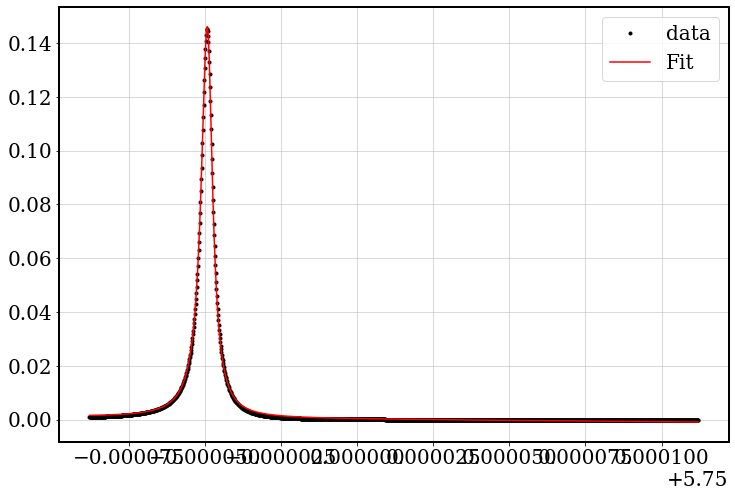

81
conversion is: dBm-W
[ 3.66300244e-06  6.24999998e-07  1.62074091e+01 -1.33477831e+02
  2.16335104e+03  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.62073310e+01 -1.33477831e+03
   2.16335104e+02  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.62075310e+01 -1.33477831e+01
   2.16335104e+04  1.00000000e+02]]
Parametro  1 :  3.569162028414713e-06  +/-  1.9473194022601975e-09
Parametro  2 :  1.4292727155216809e-06  +/-  9.638555357429613e-10
Parametro  3 :  16.207409116980223  +/-  1.2818192771495674e-09
Parametro  4 :  -13.347875176768055  +/-  0.4734532469911977
Parametro  5 :  216.33510439592484  +/-  7.6734618379061015
Parametro  6 :  1.3047695419244247  +/-  0.0023532459607324466
Q = 5.67e+06  +/-  0.0004484166188961739


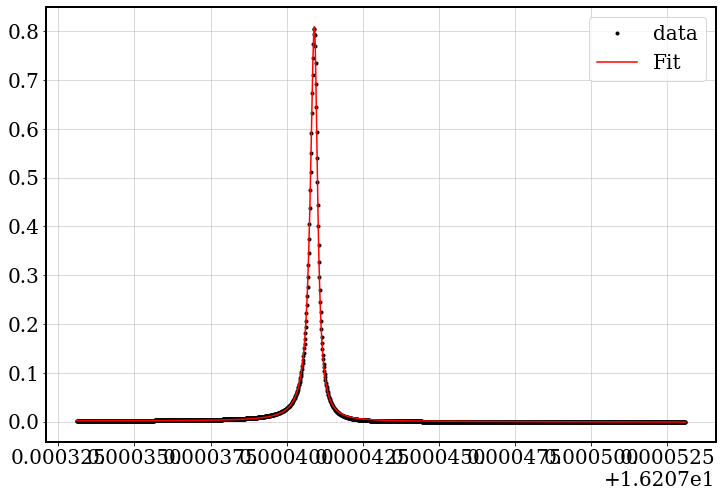

82
conversion is: dBm-W
[ 1.90414285e-06  6.24999998e-07  1.62743781e+01 -6.84342237e+01
  1.11373545e+03  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.62743000e+01 -6.84342237e+02
   1.11373545e+02  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.62745000e+01 -6.84342237e+00
   1.11373545e+04  1.00000000e+02]]
Parametro  1 :  1.7382258162943785e-06  +/-  2.5663014465729454e-09
Parametro  2 :  8.594989362823776e-07  +/-  1.2170503846452125e-09
Parametro  3 :  16.27437822990643  +/-  1.7274657808801248e-09
Parametro  4 :  -6.843461542334168  +/-  0.6167592376346327
Parametro  5 :  111.37354531256278  +/-  10.037387334536168
Parametro  6 :  1.6649898974371962  +/-  0.006885246640491617
Q = 9.47e+06  +/-  0.0010049260725975982


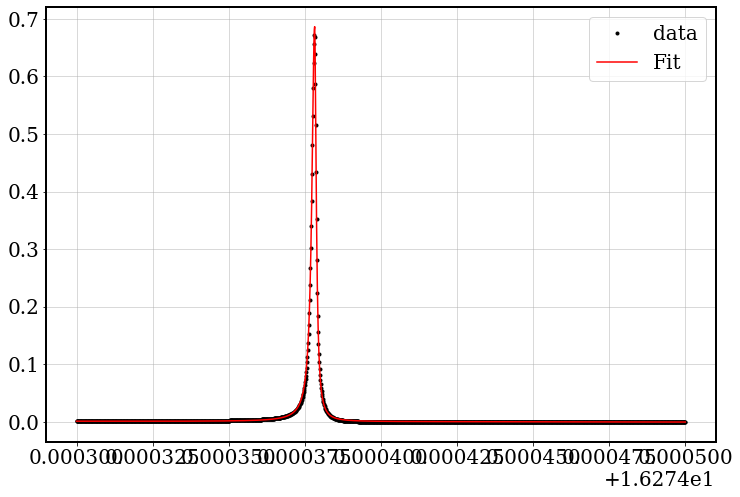

83
conversion is: dBm-W
[ 1.85875290e-06  6.24999998e-07  1.62908405e+01 -6.57180454e+01
  1.07061290e+03  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.62907620e+01 -6.57180454e+02
   1.07061290e+02  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.62909620e+01 -6.57180454e+00
   1.07061290e+04  1.00000000e+02]]
Parametro  1 :  1.6691534292950686e-06  +/-  3.4448715396320036e-09
Parametro  2 :  7.931233747730693e-07  +/-  1.4419911482537225e-09
Parametro  3 :  16.290840543338028  +/-  2.087512802026711e-09
Parametro  4 :  -6.571843851760453  +/-  0.7891047939351346
Parametro  5 :  107.06128967539615  +/-  12.85519823682363
Parametro  6 :  1.783140118616622  +/-  0.009762314266411318
Q = 1.03e+07  +/-  0.001316007615223796


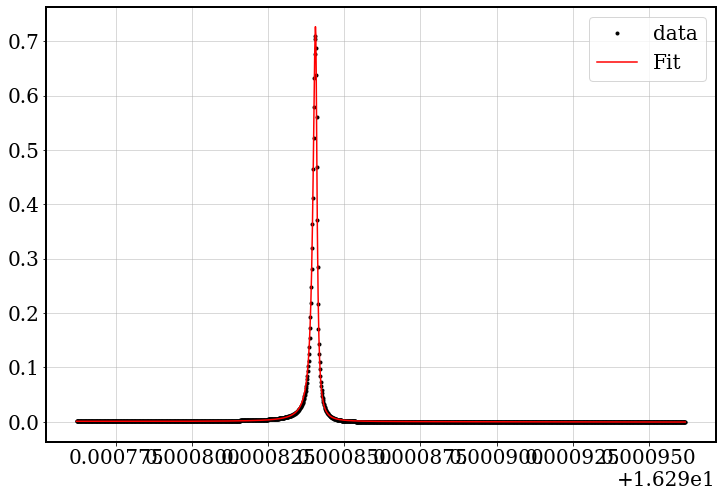

84
conversion is: dBm-W
[ 1.37851212e-06  6.24999998e-07  1.63460176e+01 -4.44433680e+01
  7.26479826e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.63459370e+01 -4.44433680e+02
   7.26479826e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.63461370e+01 -4.44433680e+00
   7.26479826e+03  1.00000000e+02]]
Parametro  1 :  1.1758729946349593e-06  +/-  4.076025294455051e-09
Parametro  2 :  7.230632093043757e-07  +/-  1.8732467471884964e-09
Parametro  3 :  16.34601766806869  +/-  2.80594852515107e-09
Parametro  4 :  -4.444361280015841  +/-  0.8328599527474337
Parametro  5 :  72.64798257032325  +/-  13.613960430839045
Parametro  6 :  2.026745922301412  +/-  0.01683526880651695
Q = 1.13e+07  +/-  0.0019403203544614992


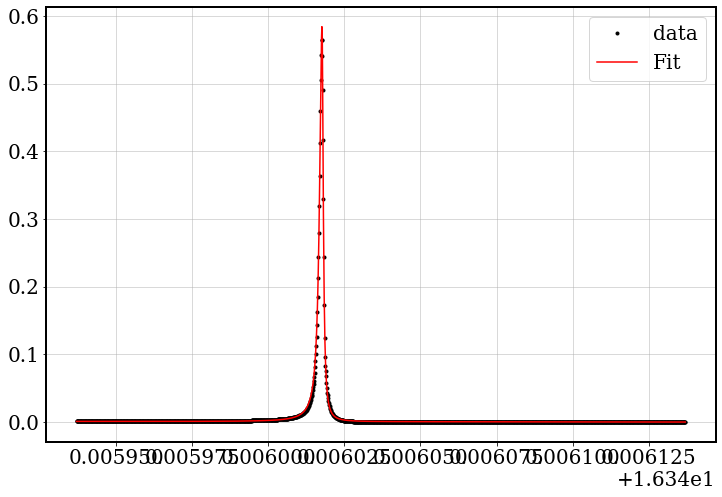

85
conversion is: dBm-W
[ 8.84472546e-07  6.25000016e-07  1.63566060e+01 -6.32923565e+01
  1.03525572e+03  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.63565560e+01 -6.32923565e+02
   1.03525572e+02  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.63567560e+01 -6.32923565e+00
   1.03525572e+04  1.00000000e+02]]
Parametro  1 :  6.679950903819334e-07  +/-  6.618504982077915e-09
Parametro  2 :  5.923014176036024e-07  +/-  3.04349306537204e-09
Parametro  3 :  16.356606176778346  +/-  4.921357194337802e-09
Parametro  4 :  -6.329423472852887  +/-  1.0423718474812458
Parametro  5 :  103.52841760393224  +/-  17.049719850307127
Parametro  6 :  2.7133292869717165  +/-  0.05240766497337689
Q = 1.38e+07  +/-  0.004154436447450325


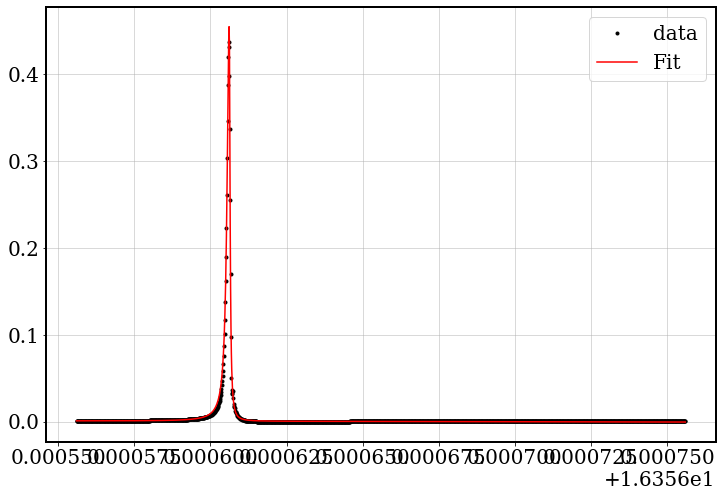

86
conversion is: dBm-W
[ 1.04966899e-06  6.24999998e-07  1.63785111e+01 -3.49954285e+01
  5.73178956e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.63784310e+01 -3.49954285e+02
   5.73178956e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.63786310e+01 -3.49954285e+00
   5.73178956e+03  1.00000000e+02]]
Parametro  1 :  8.886940054146578e-07  +/-  1.9377777527868468e-09
Parametro  2 :  8.340267001335143e-07  +/-  1.494998459251483e-09
Parametro  3 :  16.378511169004106  +/-  2.1683488158489645e-09
Parametro  4 :  -4.207669278432245  +/-  0.41344202441906214
Parametro  5 :  68.91581759189478  +/-  6.771573497630348
Parametro  6 :  1.8858229678979184  +/-  0.010394061917830745
Q = 9.82e+06  +/-  0.0012999276974597145


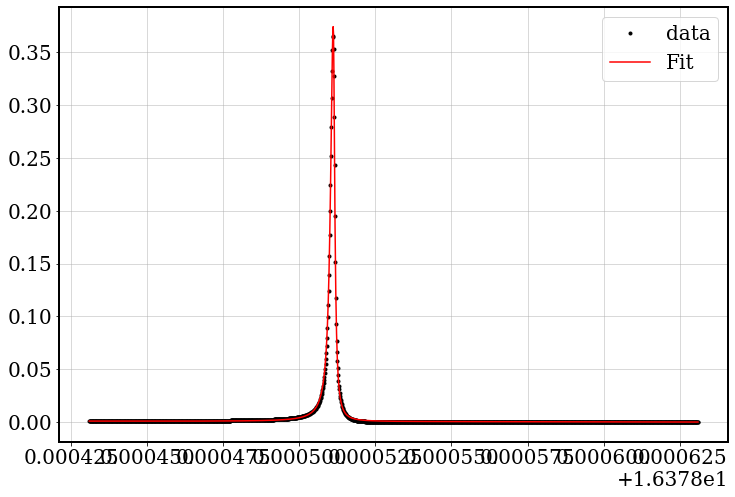

87
conversion is: dBm-W
[ 5.96414455e-07  6.24999998e-07  1.64195985e+01 -1.95483978e+01
  3.20980206e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.64195180e+01 -1.95483978e+02
   3.20980206e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.64197180e+01 -1.95483978e+00
   3.20980206e+03  1.00000000e+02]]
Parametro  1 :  4.61194271256242e-07  +/-  1.1049574379599175e-09
Parametro  2 :  9.653316562334596e-07  +/-  1.8643928683979896e-09
Parametro  3 :  16.419598630997243  +/-  2.655543193040879e-09
Parametro  4 :  -3.7052553844151346  +/-  0.22208617733402866
Parametro  5 :  60.839317600061584  +/-  3.6465704938419505
Parametro  6 :  1.925751645779221  +/-  0.011410623724776775
Q = 8.50e+06  +/-  0.001375456391538171


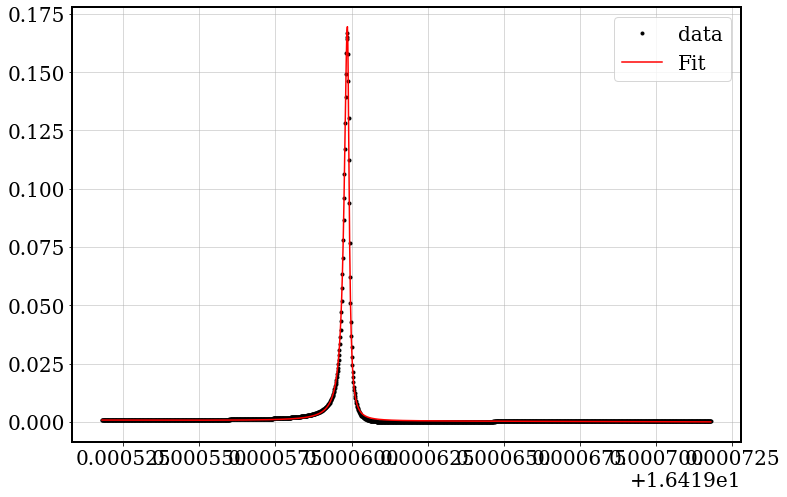

88
conversion is: dBm-W
[ 2.89550602e-07  6.25000003e-07  5.77579012e+00 -1.16030340e+01
  6.70183899e+01  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  5.77571200e+00 -1.16030340e+02
   6.70183899e+00  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  5.77591200e+00 -1.16030340e+00
   6.70183899e+02  1.00000000e+02]]
Parametro  1 :  2.8623278215819094e-07  +/-  3.64318823301518e-10
Parametro  2 :  4.738252459479015e-06  +/-  6.967007039651106e-09
Parametro  3 :  5.775790440738078  +/-  8.471180999375083e-09
Parametro  4 :  -1.6257412470928678  +/-  0.04634107373049689
Parametro  5 :  9.390003333125712  +/-  0.26765770711487347
Parametro  6 :  1.3958002869849293  +/-  0.005176194261176398
Q = 6.09e+05  +/-  0.0008939140613360694


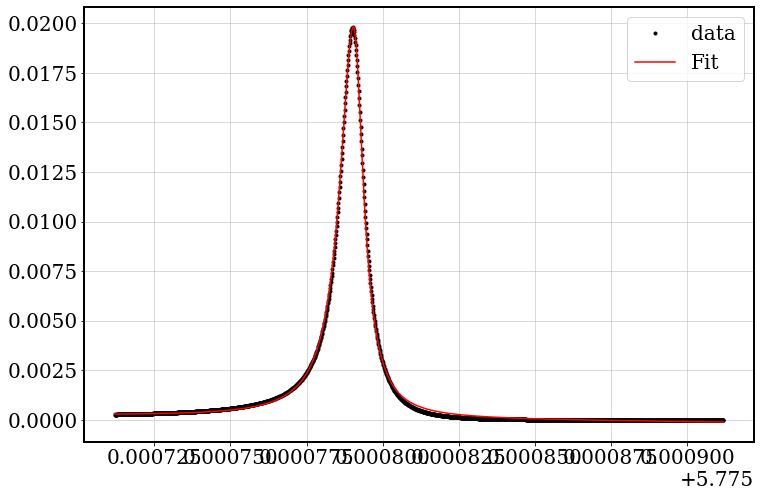

89
conversion is: dBm-W
[ 3.26228886e-07  6.24999998e-07  1.64277431e+01 -1.00869397e+01
  1.65707474e+02  1.00000000e+00] 
 [[-1.00000000e-03  2.00000000e-07  1.64276620e+01 -1.00869397e+02
   1.65707474e+01  0.00000000e+00]
 [ 1.00000000e-03  2.00000000e-02  1.64278620e+01 -1.00869397e+00
   1.65707474e+03  1.00000000e+02]]
Parametro  1 :  2.0242358175189286e-07  +/-  9.208566893615908e-10
Parametro  2 :  1.1959449194865383e-06  +/-  3.778093536085369e-09
Parametro  3 :  16.427743330302214  +/-  5.262897875524395e-09
Parametro  4 :  -2.8856648224360866  +/-  0.1540253615172864
Parametro  5 :  47.40547682028534  +/-  2.5302922415962934
Parametro  6 :  2.217138328615989  +/-  0.022265937756124492
Q = 6.87e+06  +/-  0.0022003094748644244


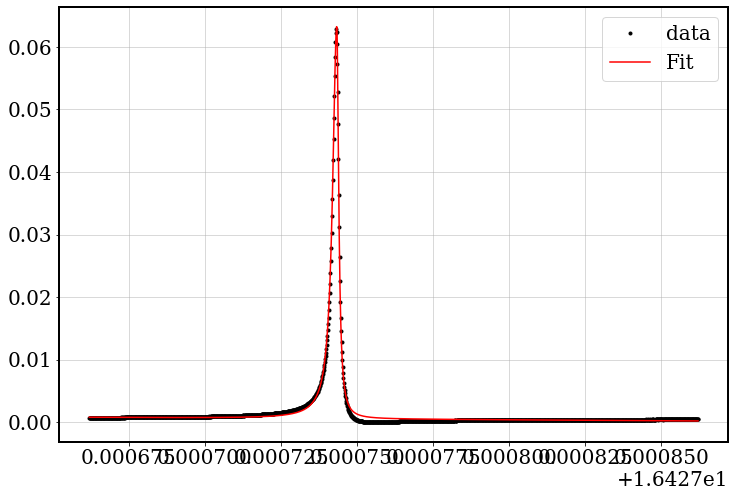

In [5]:
from process import utils


for loc in locs:
    print(loc)
    power = reader.get_resonance(loc=loc,label='S21')['power']
    phase = reader.get_resonance(loc=loc,label='S21')['phase']
    freq = reader.get_resonance(loc=loc,label='S21')['freq']

    utils.fit_resonance(freq*1e-6, power,verbose=True)
    #plt.plot(freq,power)
    #plt.plot(freq,phase)
    #power = reader.get_resonance(loc=l,label='S11')['power']
    #freq = reader.get_resonance(loc=l,label='S11')['freq']
    #phase = reader.get_resonance(loc=l,label='S11')['phase']
    #plt.plot(freq,power)
    #plt.plot(freq,phase)
    
    #plt.legend()
    #plt.xlabel('Sample number')
    #plt.ylabel('Power [dB]')
    #plt.grid(alpha=0.6)
    #plt.show()